# Clustering 150k+ cells PGCLCs from Arend 

### Resources
* Preprocessing and clustering tutorial: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html
* Legacy workflow PBMCs https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html


In [1]:
# env CUDA_VISIBLE_DEVICES=0

memory_profiler is used to estimate the memory usage for each step. Useful to estimate the amount of memory to request when working on cluster

In [1]:
%load_ext memory_profiler

## Load libraries

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [4]:
# Only required when using GPUs
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
print(sc.__version__)
print(pd.__version__)

1.10.1
2.2.2


In [6]:
# ! echo $CUDA_VISIBLE_DEVICES

In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/exports/sasc/ioannis/mambaforge/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


## Load raw data

### Automatically load data
Set `INPUT_PATH` to the directory with cellranger output. The name of the first subdir in there is the run identifier. 

Recurcively walk inside the subdir and get the full path of the `sample_filtered_feature_bc_matrix.h5` file. Load it and run `var_names_make_unique()`

In [ ]:
%%memit
INPUT_PATH = "/path/to/outs/per_sample_outs/"

# Get the subdirectory names, which are our samples ids
sample_ids = next(os.walk(INPUT_PATH))[1]

# Loop through each sample dir and get the corresponding h5 file. Save them in separate lists
run_list = []
h5_tables = []
for sample in sample_ids:
    for root, dirs, files in os.walk("/exports/sasc/project-480-PGCLC_10x_arend/data/202400154_count/outs/per_sample_outs/" + sample):
        if "sample_filtered_feature_bc_matrix.h5" in files:
            h5_path = os.path.join(root, "sample_filtered_feature_bc_matrix.h5")
            run_list.append(sample)
            h5_table = sc.read_10x_h5(h5_path)
            h5_table.var_names_make_unique()
            h5_tables.append(h5_table)


In [9]:
%%memit
adata = sc.concat(h5_tables,
                  label="run",
                  keys=run_list,
                  index_unique="_",
                  )
adata.obs_names_make_unique()
adata

peak memory: 10979.49 MiB, increment: 5132.24 MiB


## Extend annotation 
TODO: add more anotation, see notes from Susana

In [10]:
adata.obs['cell_line'] = adata.obs['run'].str.split("_", expand=True)[0]
adata.obs['day'] = adata.obs['run'].str.split("_", expand=True)[1]

In [11]:
adata.obs

run  \
AAACAAGCAAATATGCAACGGGAA-1_994_D22_B_S_pTBCASFX...     994_D22_B_S_pTBCASFX_nr15   
AAACAAGCAATGGCCGAACGGGAA-1_994_D22_B_S_pTBCASFX...     994_D22_B_S_pTBCASFX_nr15   
AAACAAGCAGATAACTAACGGGAA-1_994_D22_B_S_pTBCASFX...     994_D22_B_S_pTBCASFX_nr15   
AAACAAGCATTACACCAACGGGAA-1_994_D22_B_S_pTBCASFX...     994_D22_B_S_pTBCASFX_nr15   
AAACCAATCAAGCGATAACGGGAA-1_994_D22_B_S_pTBCASFX...     994_D22_B_S_pTBCASFX_nr15   
...                                                                          ...   
TTTGGACGTCACAGGGAGTGAGTG-1_318_D30_B_S_pTBCASFX...  318_D30_B_S_pTBCASFX_2X_nr21   
TTTGGACGTGCGGAATAGTGAGTG-1_318_D30_B_S_pTBCASFX...  318_D30_B_S_pTBCASFX_2X_nr21   
TTTGGCGGTCTATCTTAGTGAGTG-1_318_D30_B_S_pTBCASFX...  318_D30_B_S_pTBCASFX_2X_nr21   
TTTGTGAGTAGCCACCAGTGAGTG-1_318_D30_B_S_pTBCASFX...  318_D30_B_S_pTBCASFX_2X_nr21   
TTTGTGAGTTAGCATCAGTGAGTG-1_318_D30_B_S_pTBCASFX...  318_D30_B_S_pTBCASFX_2X_nr21   

                                                   cell_line  day  
AAACAAGCAAATATGCAACGGGAA-1_994_D22_B_S_pTBCASFX...       994  D22  
AAACAAGCAATGGCCGAACGGGAA-1_994_D22_B_S_pTBCASFX...       994  D22  
AAACAAGCAGATAACTAACGGGAA-1_994_D22_B_S_pTBCASFX...       994  D22  
AAACAAGCATTACACCAACGGGAA-1_994_D22_B_S_pTBCASFX...       994  D22  
AAACCAATCAAGCGATAACGGGAA-1_994_D22_B_S_pTBCASFX...       994  D22  
...                                                      ...  ...  
TTTGGACGTCACAGGGAGTGAGTG-1_318_D30_B_S_pTBCASFX...       318  D30  
TTTGGACGTGCGGAATAGTGAGTG-1_318_D30_B_S_pTBCASFX...       318  D30  
TTTGGCGGTCTATCTTAGTGAGTG-1_318_D30_B_S_pTBCASFX...       318  D30  
TTTGTGAGTAGCCACCAGTGAGTG-1_318_D30_B_S_pTBCASFX...       318  D30  
TTTGTGAGTTAGCATCAGTGAGTG-1_318_D30_B_S_pTBCASFX...       318  D30  

[157571 rows x 3 columns]

## Basic Filtering

In [12]:
%%memit
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 6 cells that have less than 200 genes expressed
filtered out 620 genes that are detected in less than 3 cells
peak memory: 21158.14 MiB, increment: 10180.39 MiB


## Quality Control
The scanpy function calculate_qc_metrics() calculates common quality control (QC) metrics, which are largely based on calculateQCMetrics from scater [[McCarthy et al., 2017](https://academic.oup.com/bioinformatics/article/33/8/1179/2907823?login=false)]. One can pass specific gene population to calculate_qc_metrics() in order to calculate proportions of counts for these populations. Mitochondrial, ribosomal and hemoglobin genes are defined by distinct prefixes as listed below.

In [13]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [14]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

One can now inspect violin plots of some of the computed QC metrics:
* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes


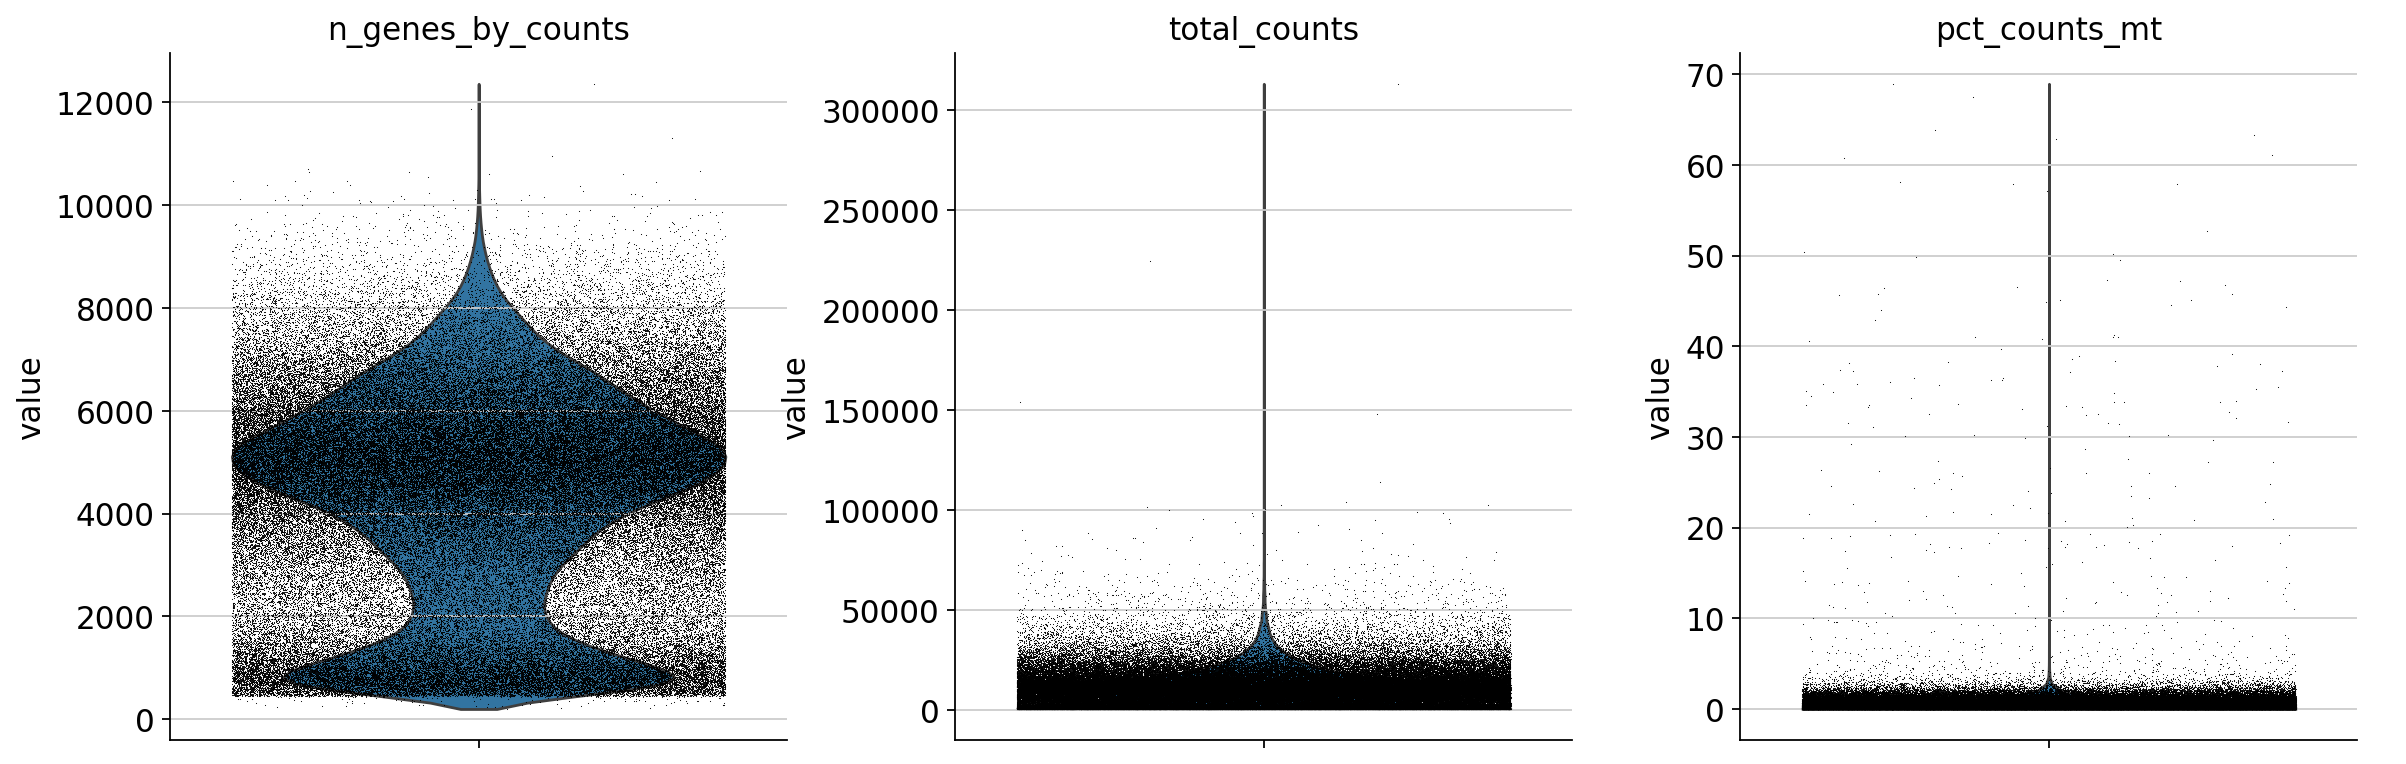

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    size=0.5,
    multi_panel=True,
)

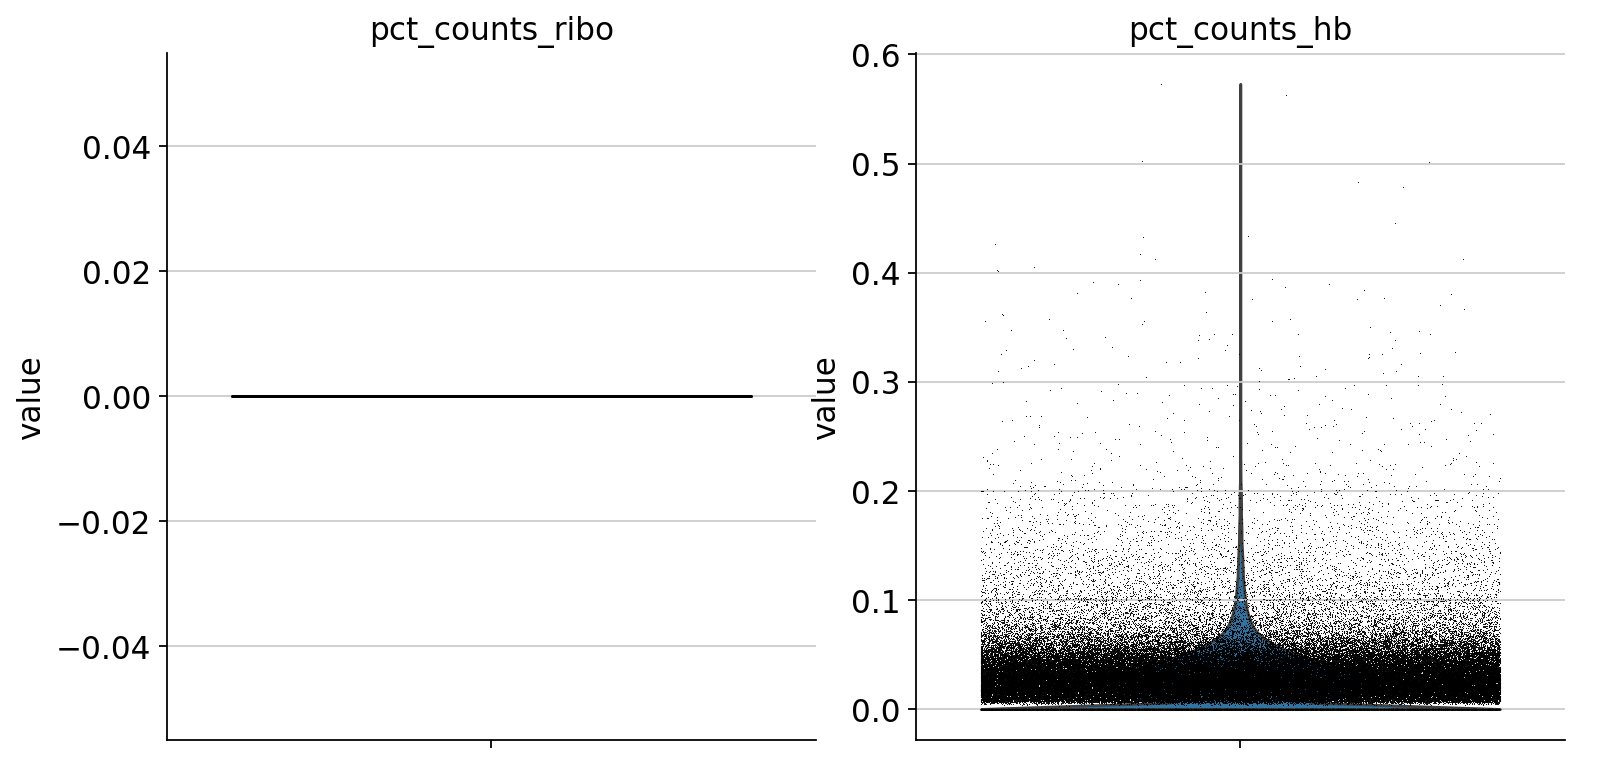

In [16]:
sc.pl.violin(
    adata,
    ["pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    size=0.5,
    multi_panel=True,
)

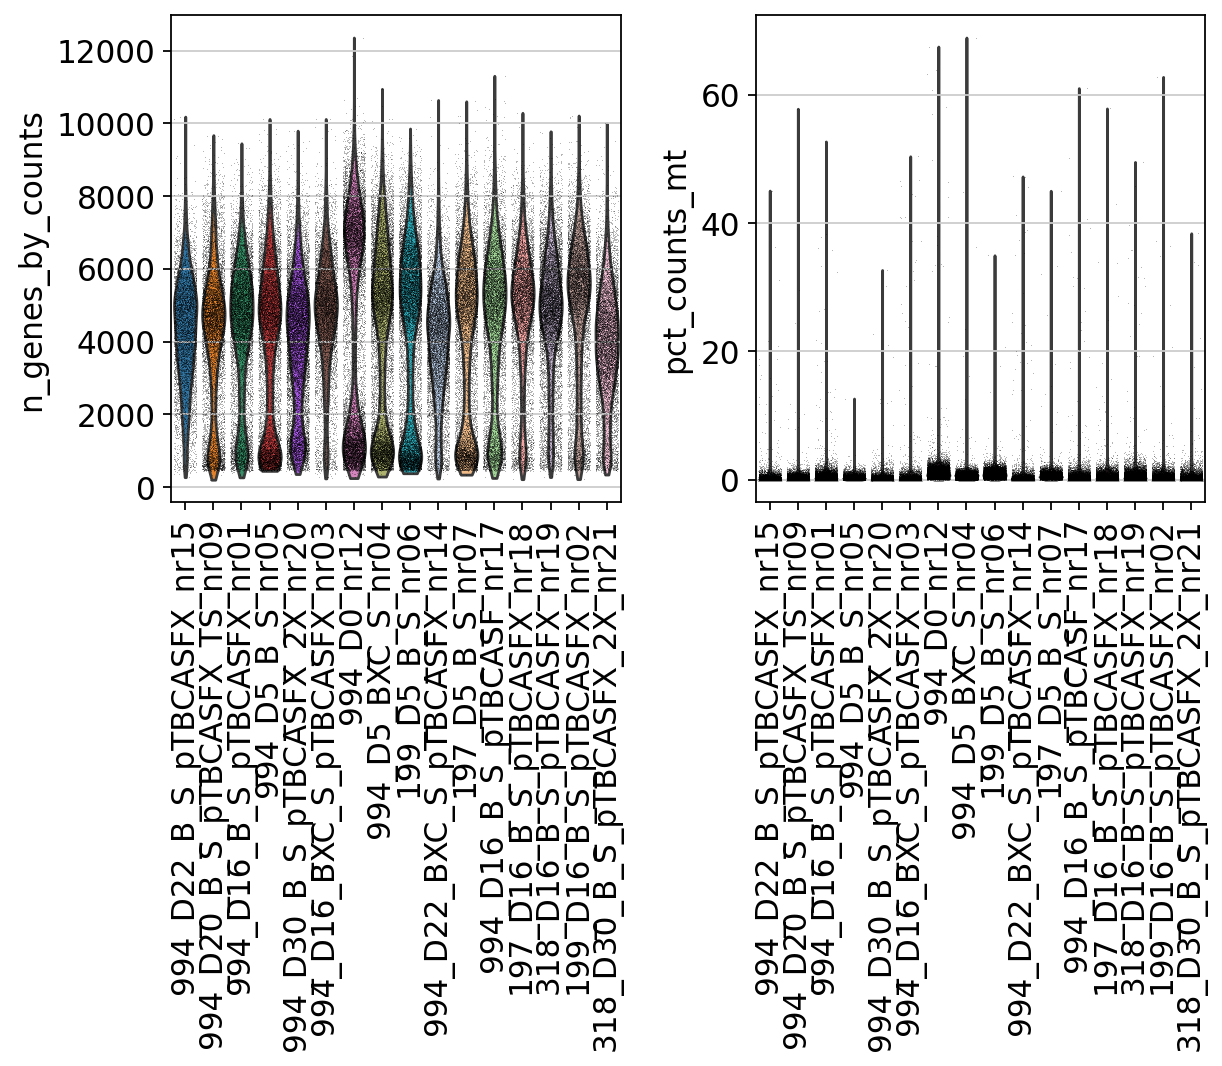

In [17]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "pct_counts_mt"],
    jitter=0.4,
    size=0.2,
    multi_panel=True,
    groupby="run",
    rotation=90,
)

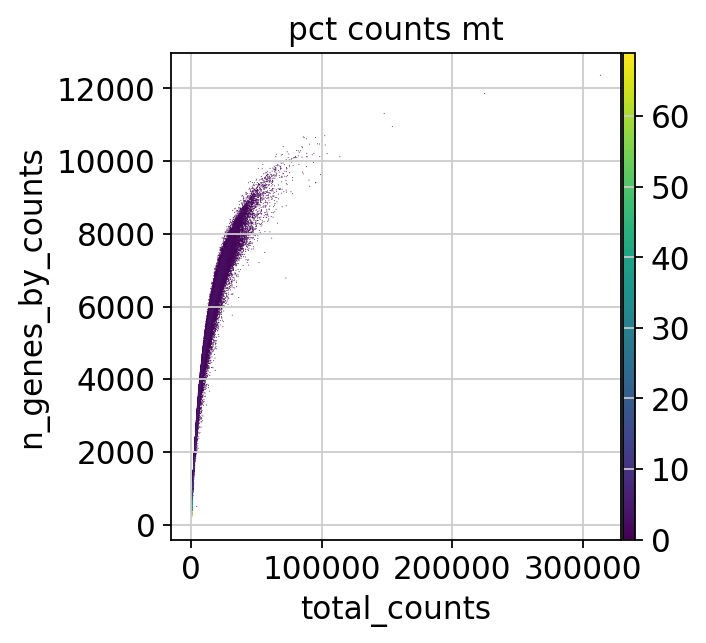

In [18]:
sc.pl.scatter(adata, "total_counts", 
              "n_genes_by_counts", 
              color="pct_counts_mt",
              )

## QC
QC on n_genes and percentage of mitochondria

In [19]:
adata = adata[(adata.obs.n_genes_by_counts < 9000) & (adata.obs.n_genes_by_counts > 2000), :]
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
adata

AnnData object with n_obs × n_vars = 124004 × 17462
    obs: 'run', 'cell_line', 'day', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'run_colors'

## Doublet detection
As a next step, we run a doublet detection algorithm. Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scanpy contains the doublet detection method Scrublet [Wolock et al., 2019]. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. scanpy.pp.scrublet() adds doublet_score and predicted_doublet to .obs. One can now either filter directly on predicted_doublet or use the doublet_score later during clustering to filter clusters with high doublet scores.

In [20]:
%%memit
sc.pp.scrublet(adata, 
batch_key="run",
)
adata.write_h5ad('adata_scrublet.h5ad')

Running Scrublet
filtered out 1751 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.8%
filtered out 1640 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata

In [3]:
# adata.write_h5ad('adata_scrublet.h5ad')
# adata = sc.read_h5ad('adata_scrublet.h5ad')

## Doublets in dataset 

In [4]:
adata.obs["predicted_doublet"].value_counts()

predicted_doublet
False    122329
True       1675
Name: count, dtype: int64

# Plot the doublet_score
* Singlets are plotted blue, doublets red
* Singlets and doublets `doublet score` overlap. One whould expect there is a universal threshold of doublet score, above which a cells is marked as doublet. This is not the case here, as the doubler score is decided for each batch (or run) individually

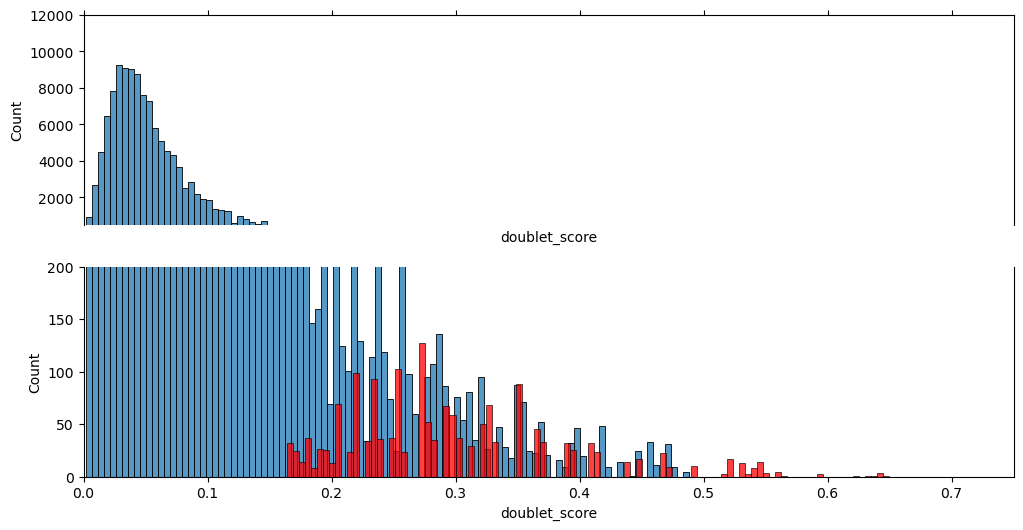

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
adata_singlets = adata[~adata.obs["predicted_doublet"],:]
adata_doublets = adata[adata.obs["predicted_doublet"],:]

# Plot the sinlgets in two plots
sns.histplot(adata_singlets.obs["doublet_score"], 
             bins=100,
             ax=ax1,
             )
sns.histplot(adata_singlets.obs["doublet_score"], 
             bins=100,
             ax=ax2,
             )

# Plot the doublets in the ax2 plot with the zoomed-in y-axis
sns.histplot(adata_doublets.obs["doublet_score"], 
             bins=100, 
             color='red',
             ax=ax2,
             );
ax1.set_ylim(500,12000)
ax2.set_ylim(0,200)
ax1.set_xlim(0,0.75)
ax2.set_xlim(0,0.75)
# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

plt.show()

## Plot each batch individually
* To test the above hypothesis, redo the above plot for each batch individually
* Plot the individual threshold value stored in the adata object
* The `doublet_score` threshold is indeed decided individually per batch

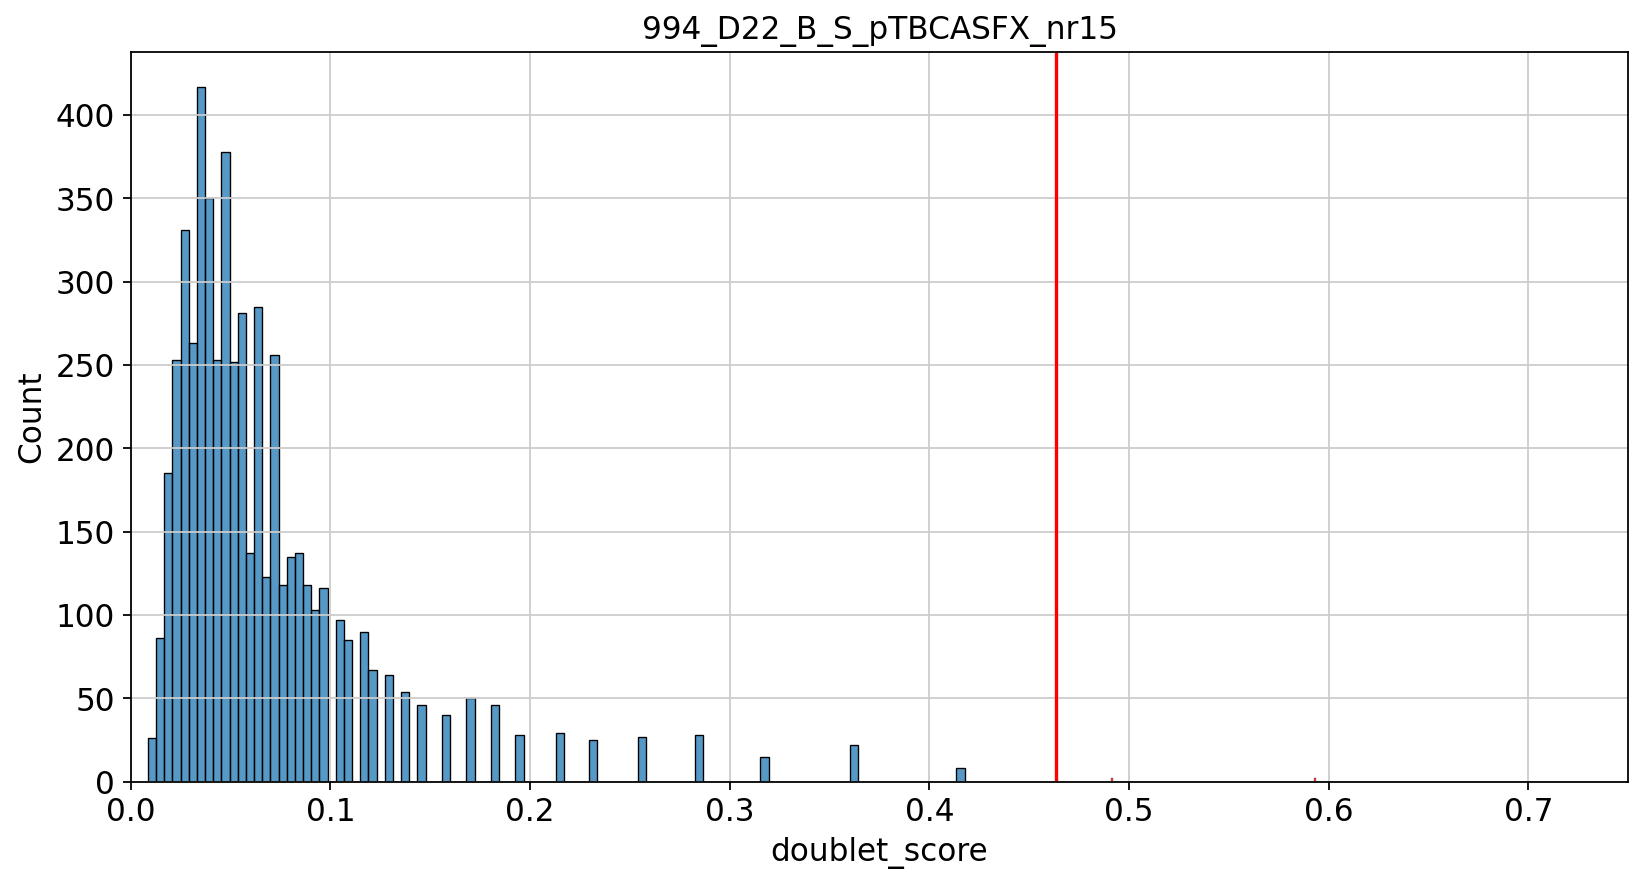

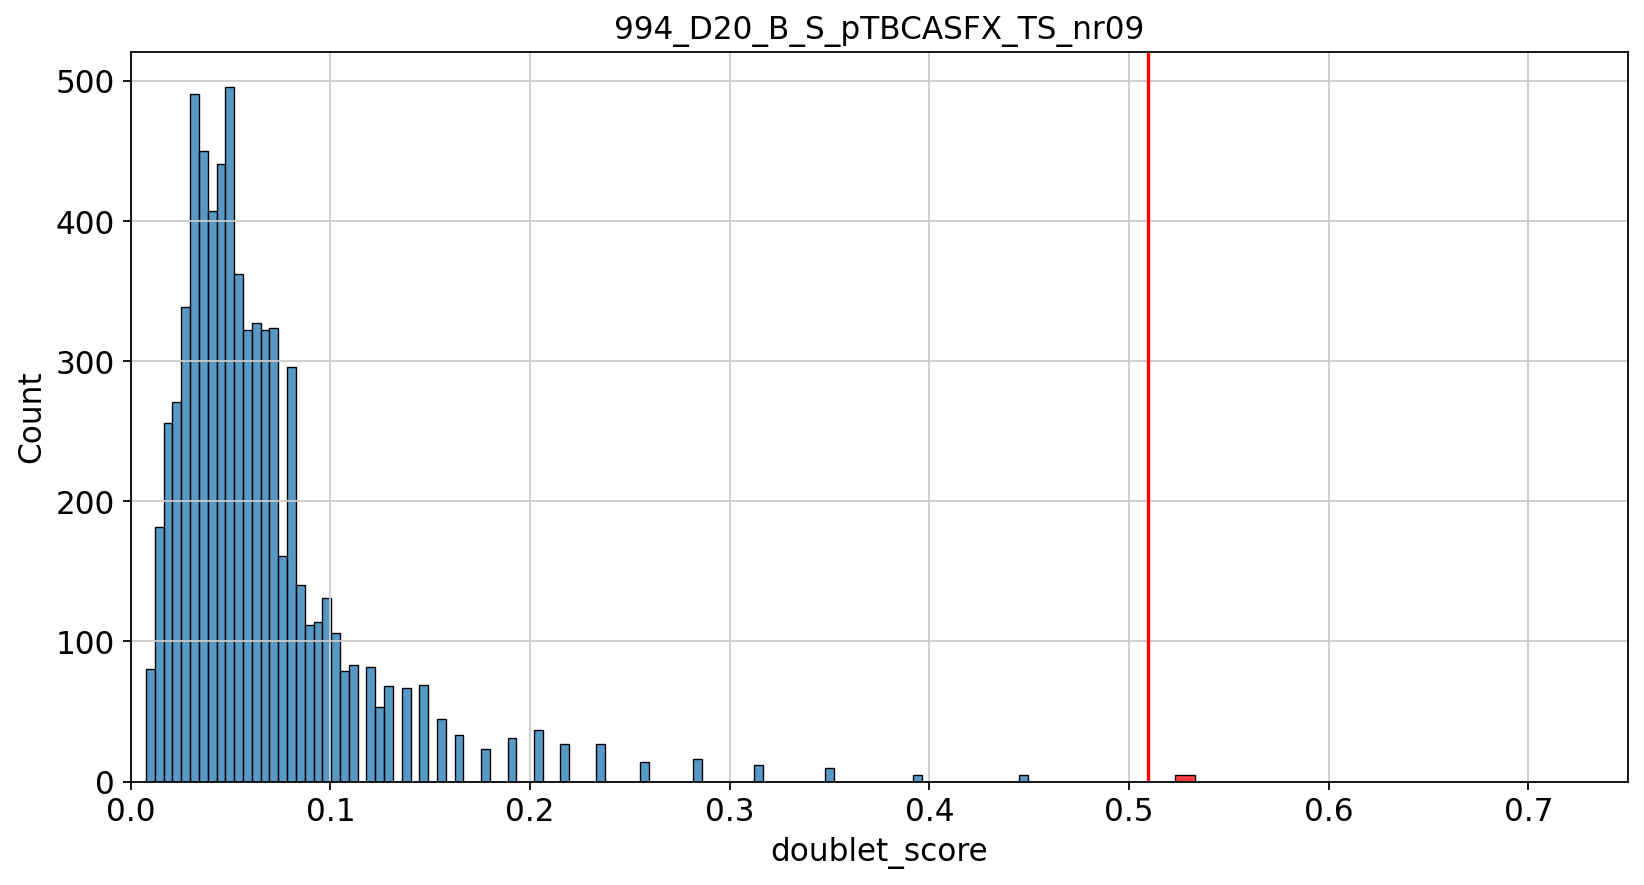

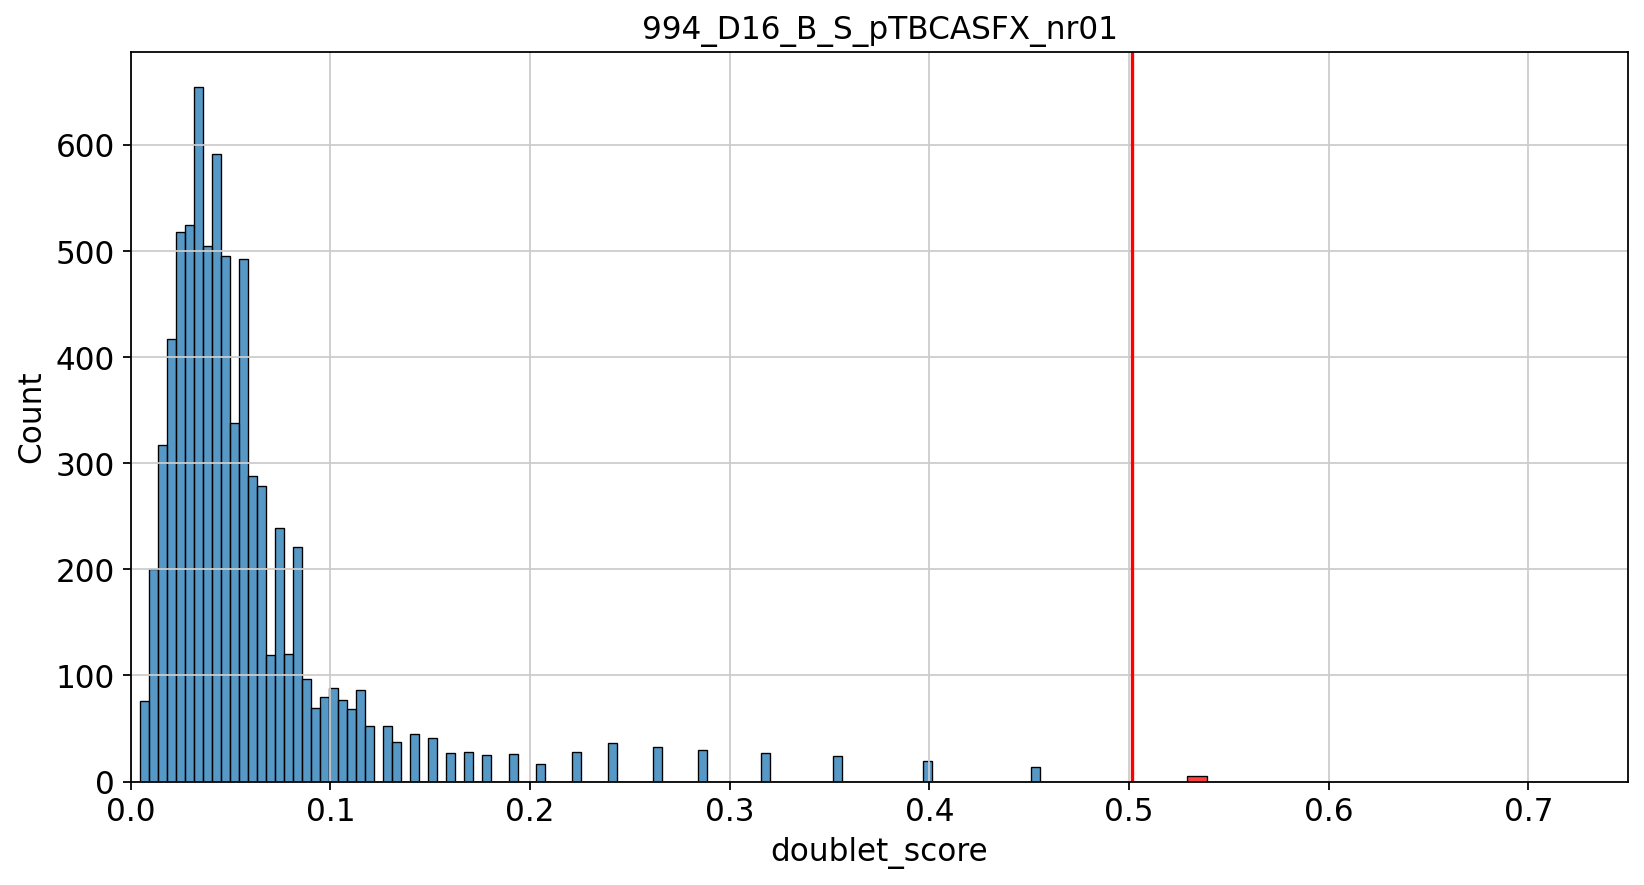

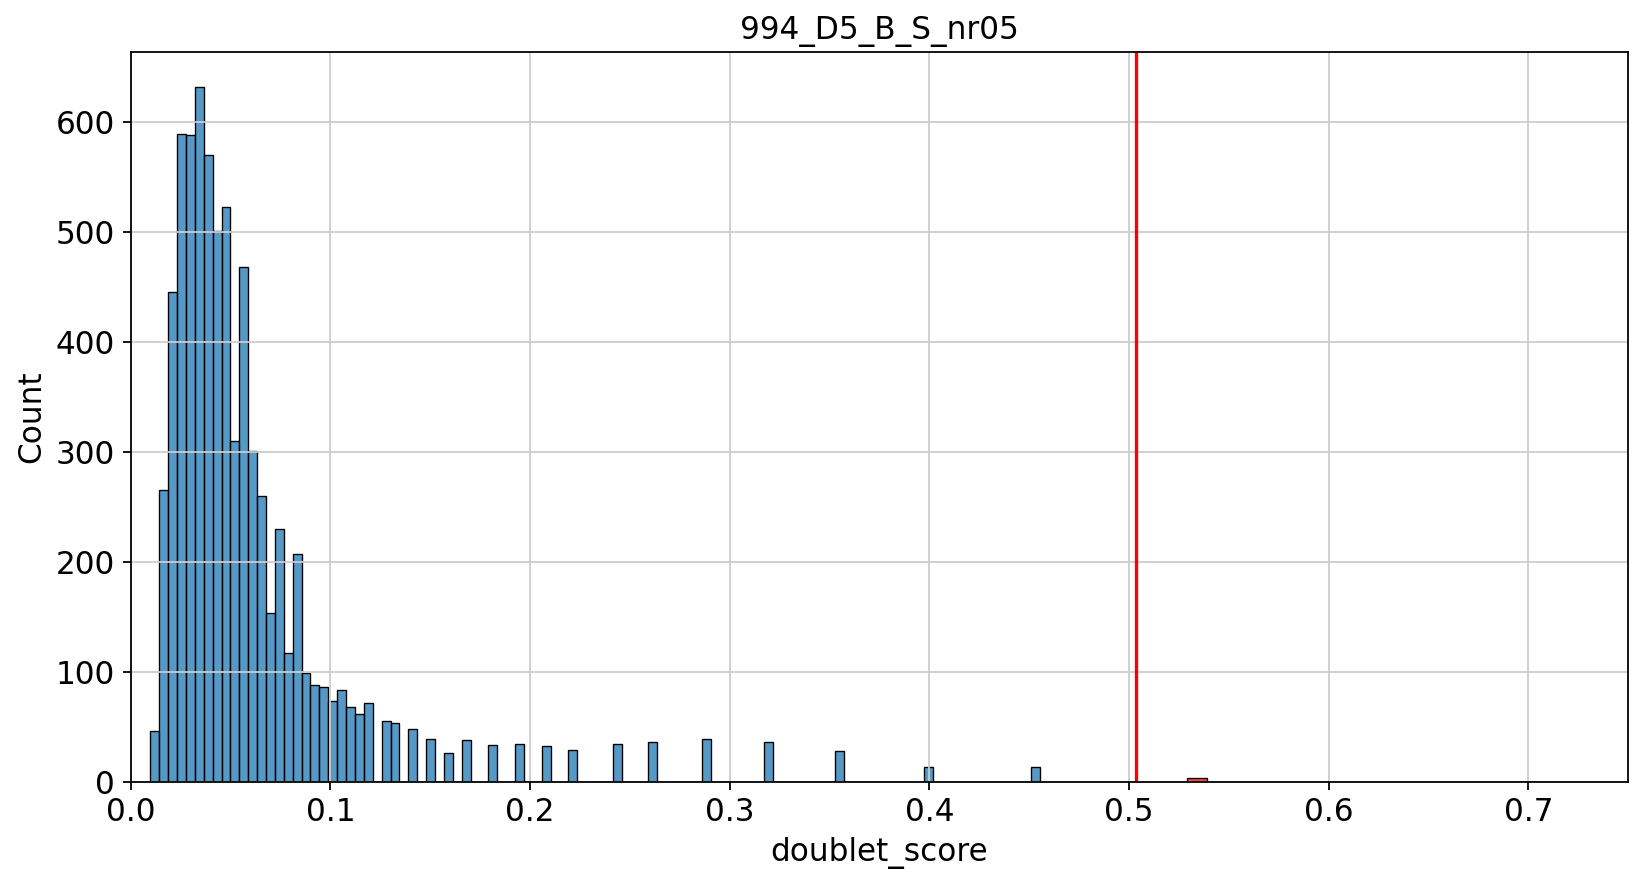

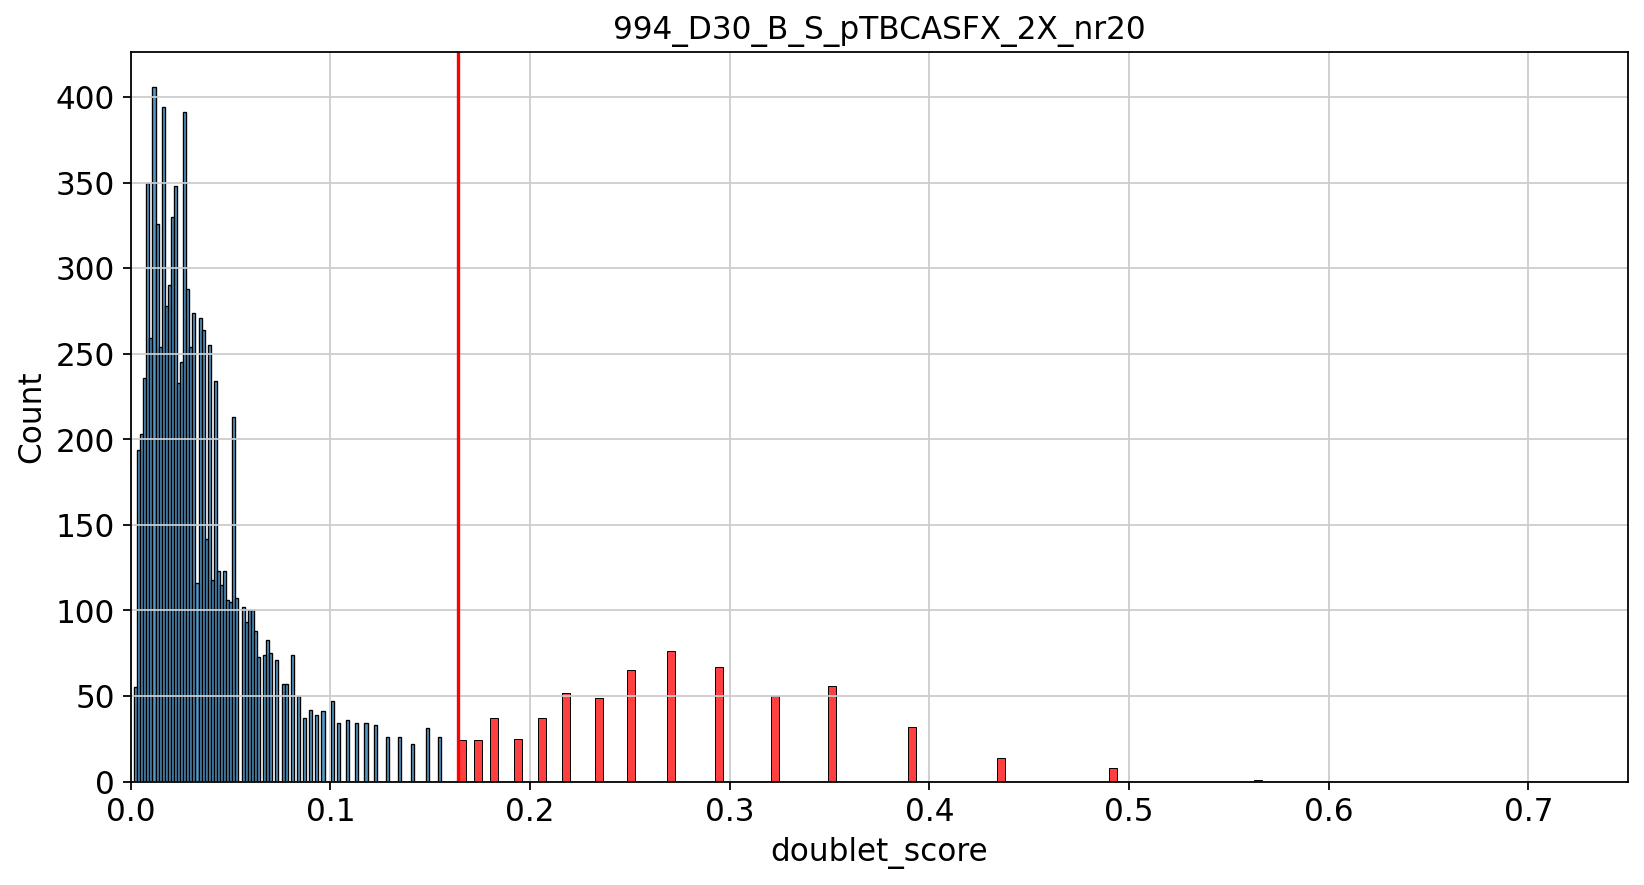

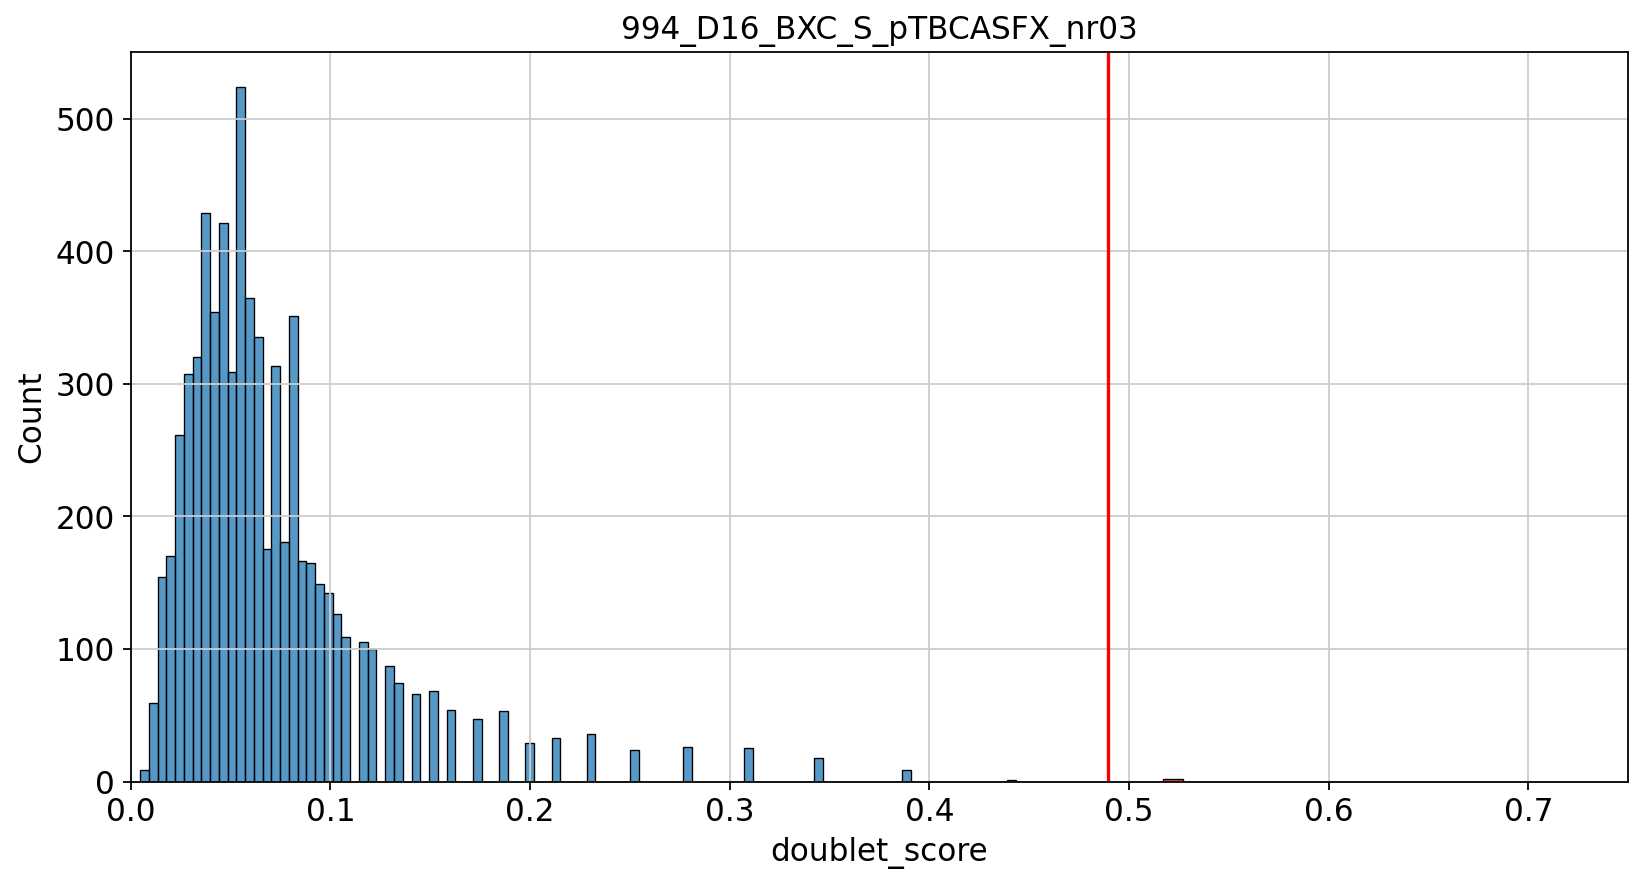

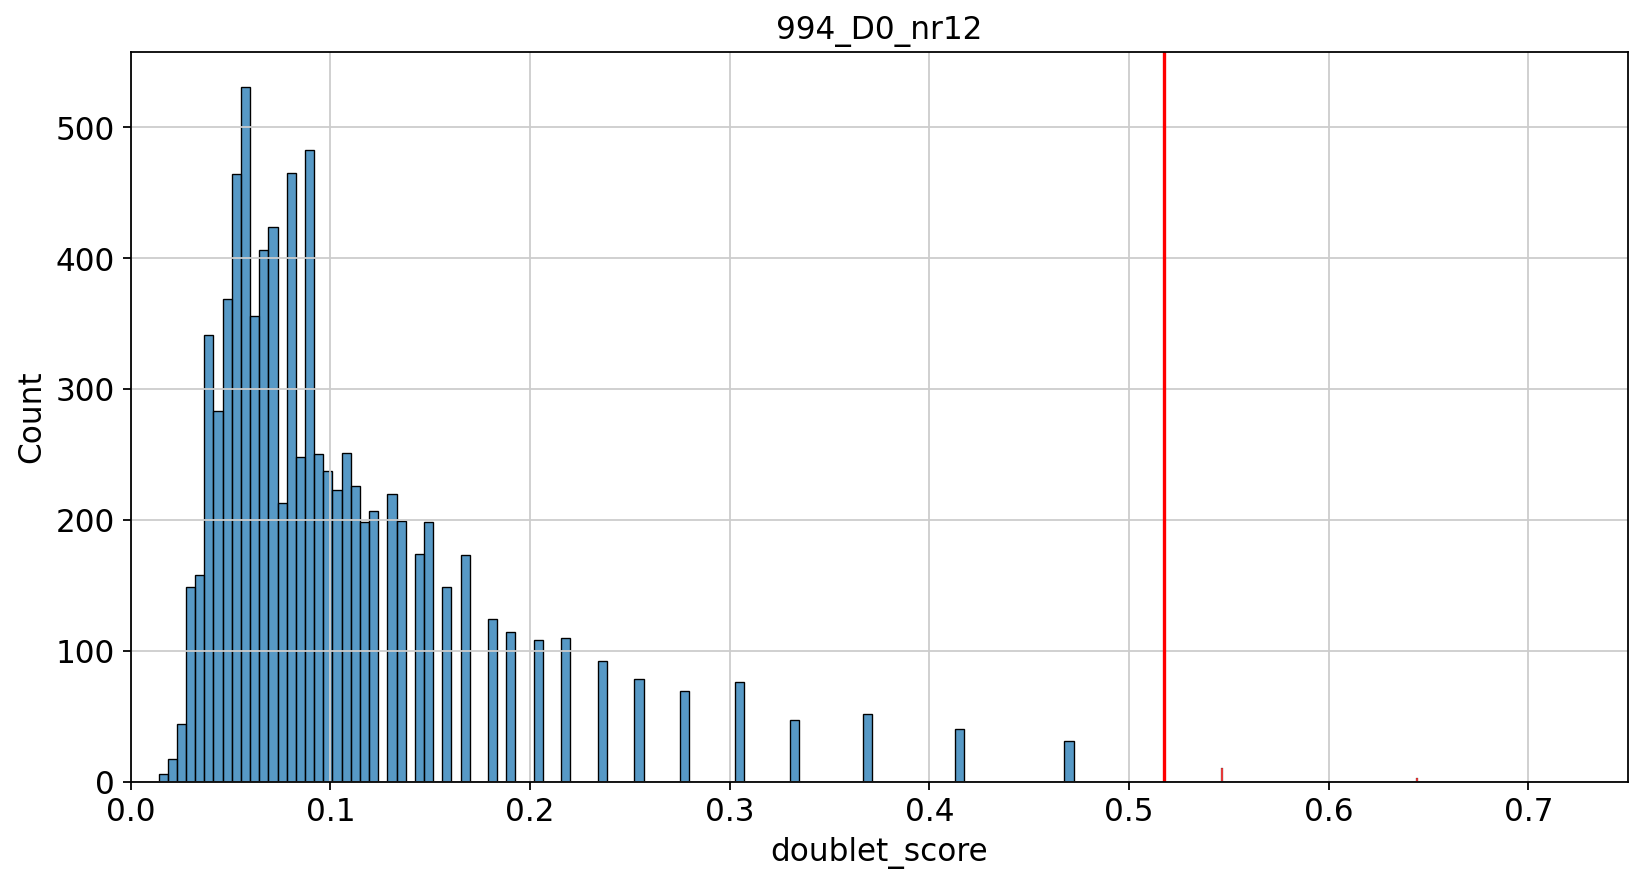

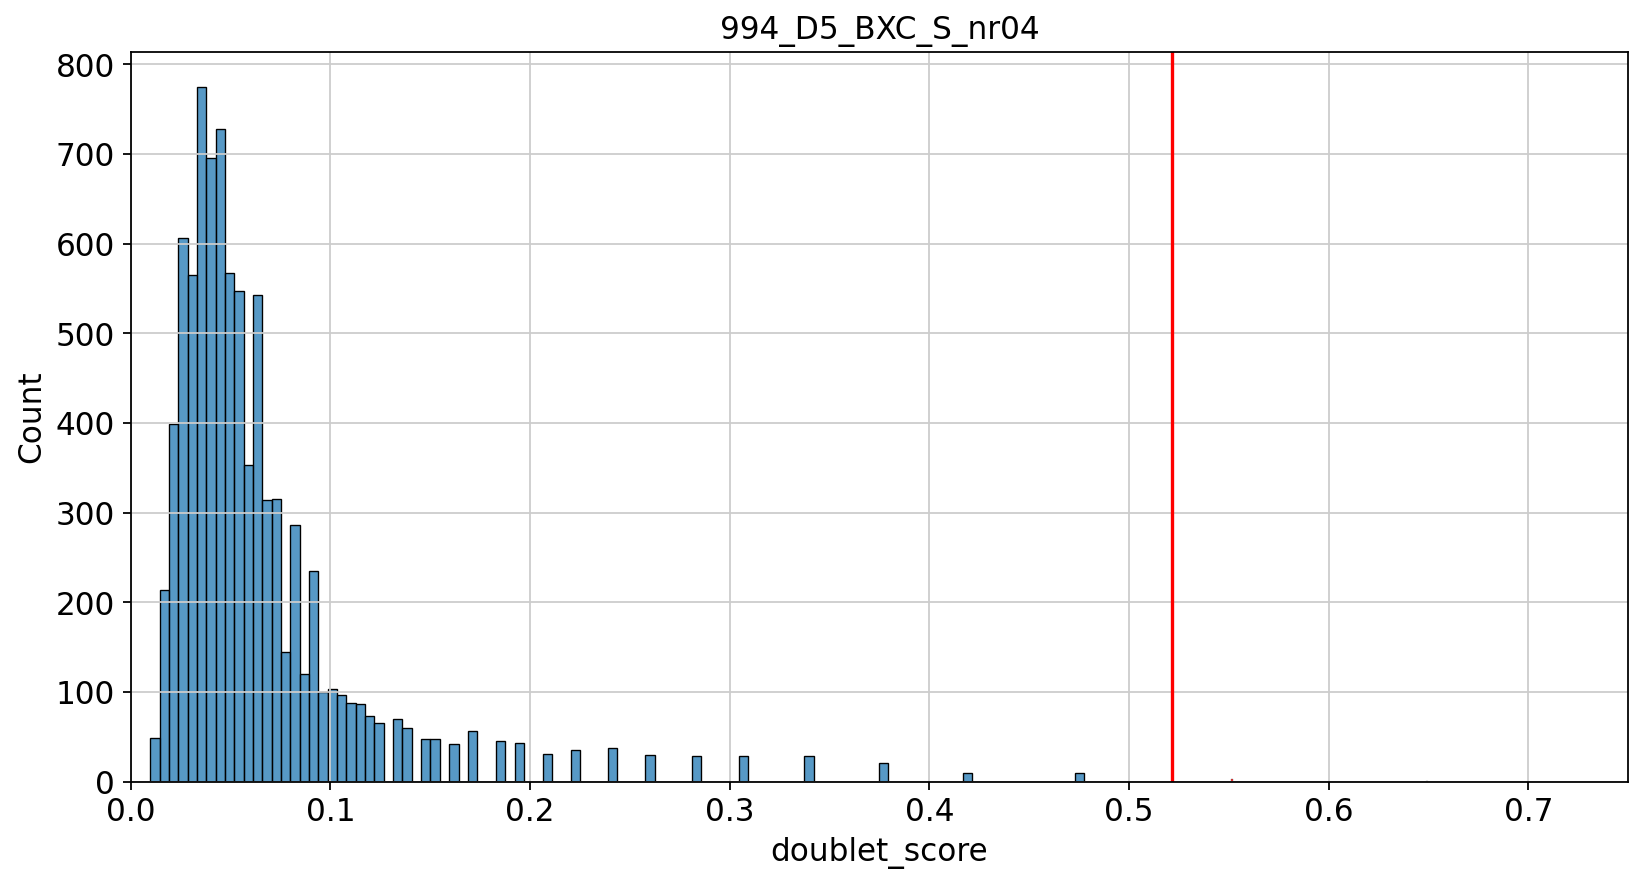

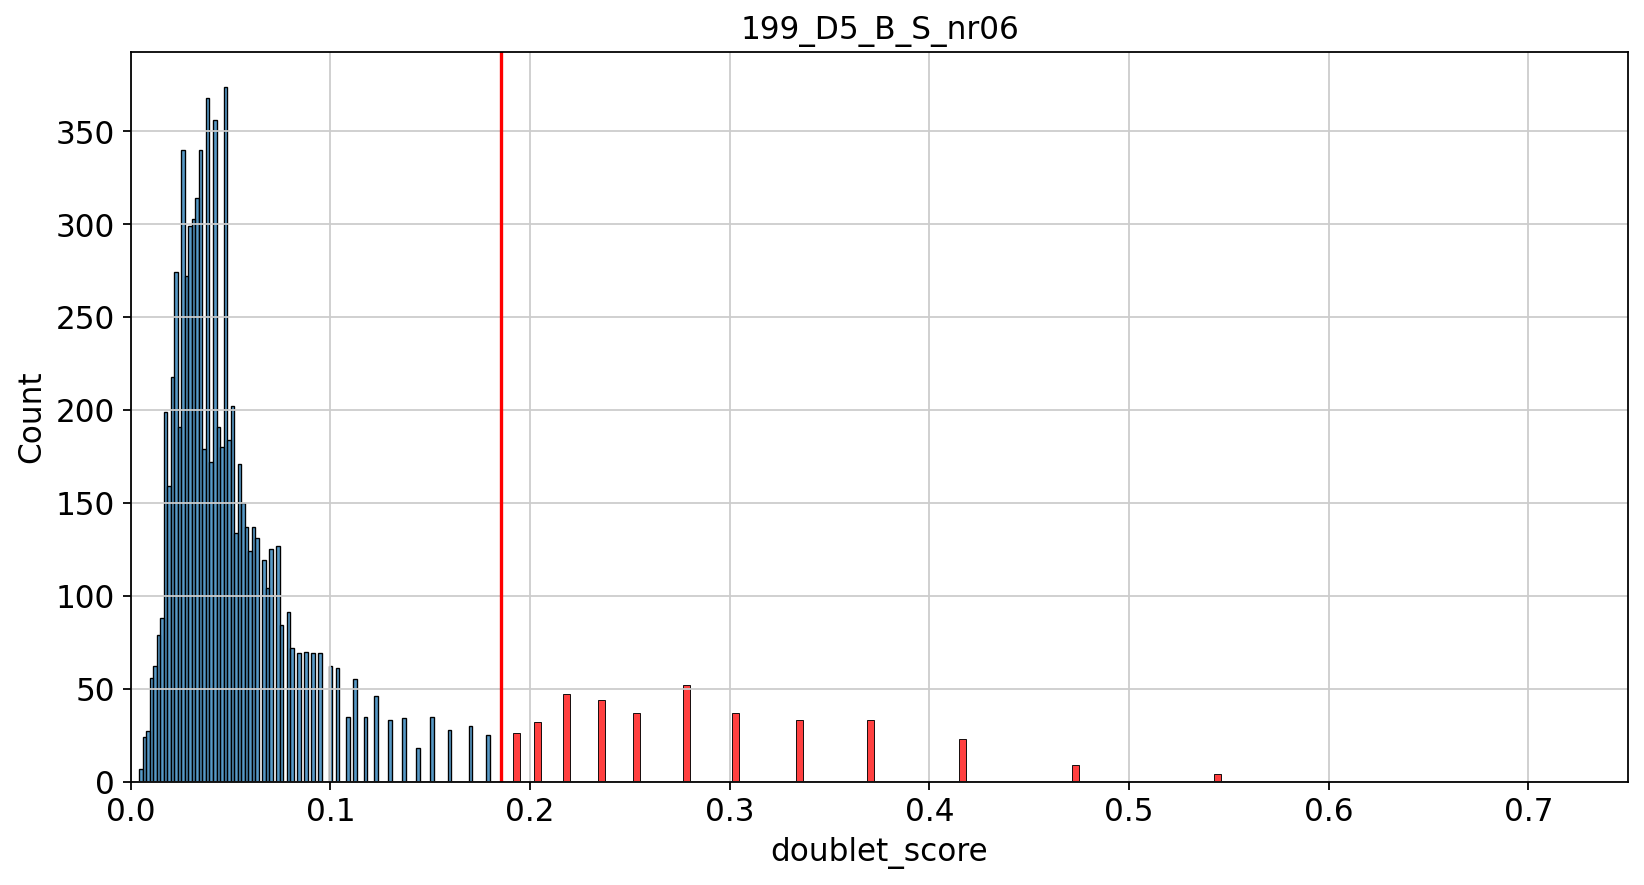

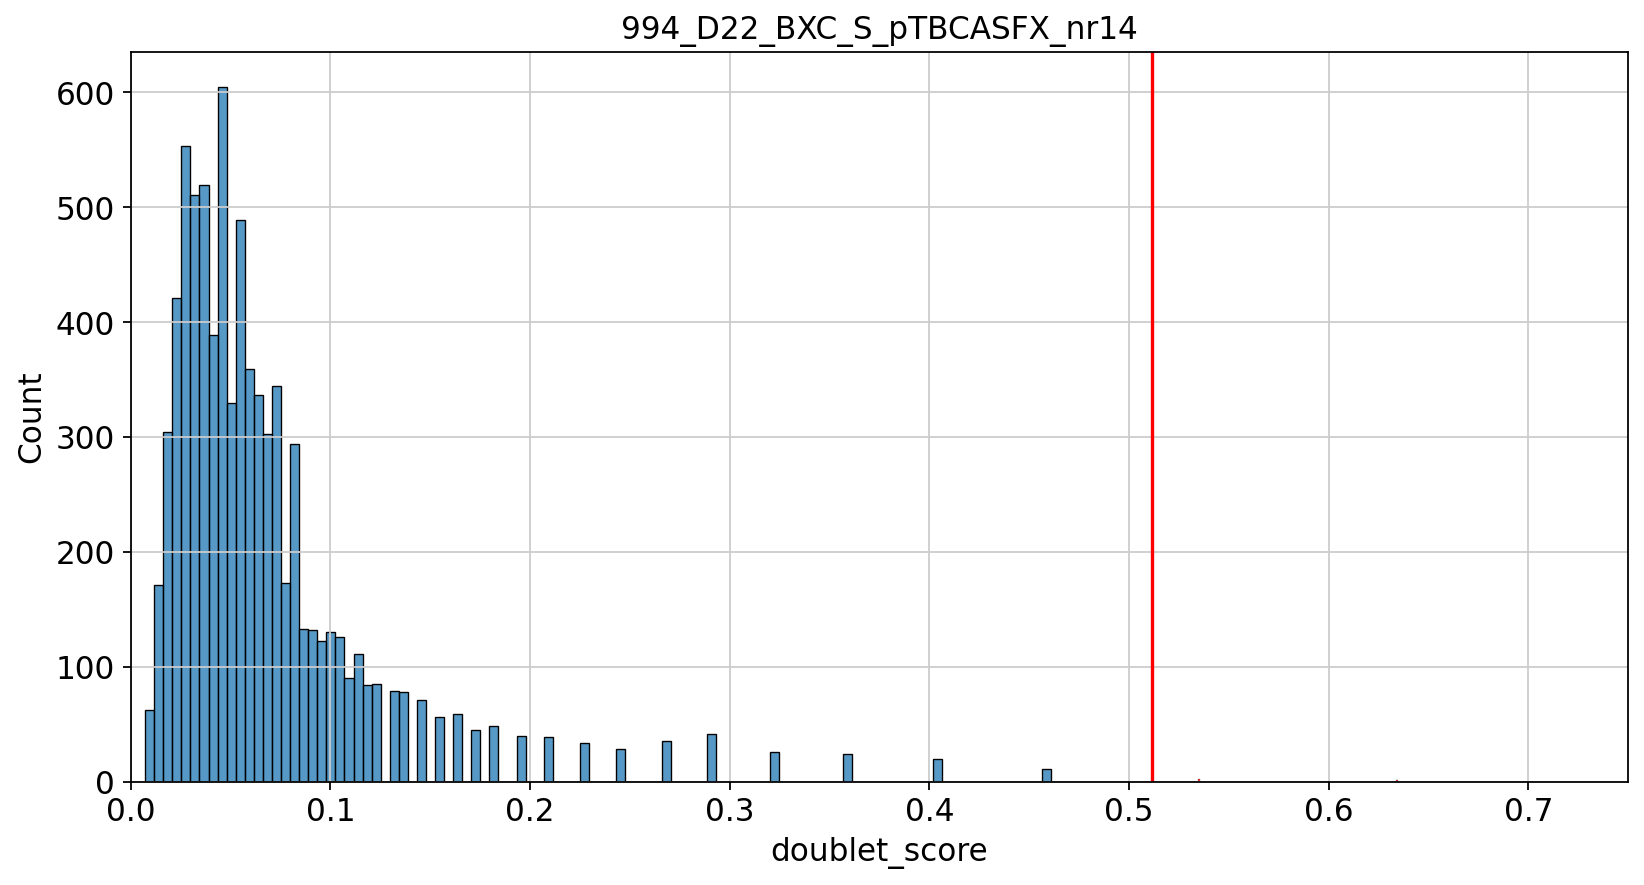

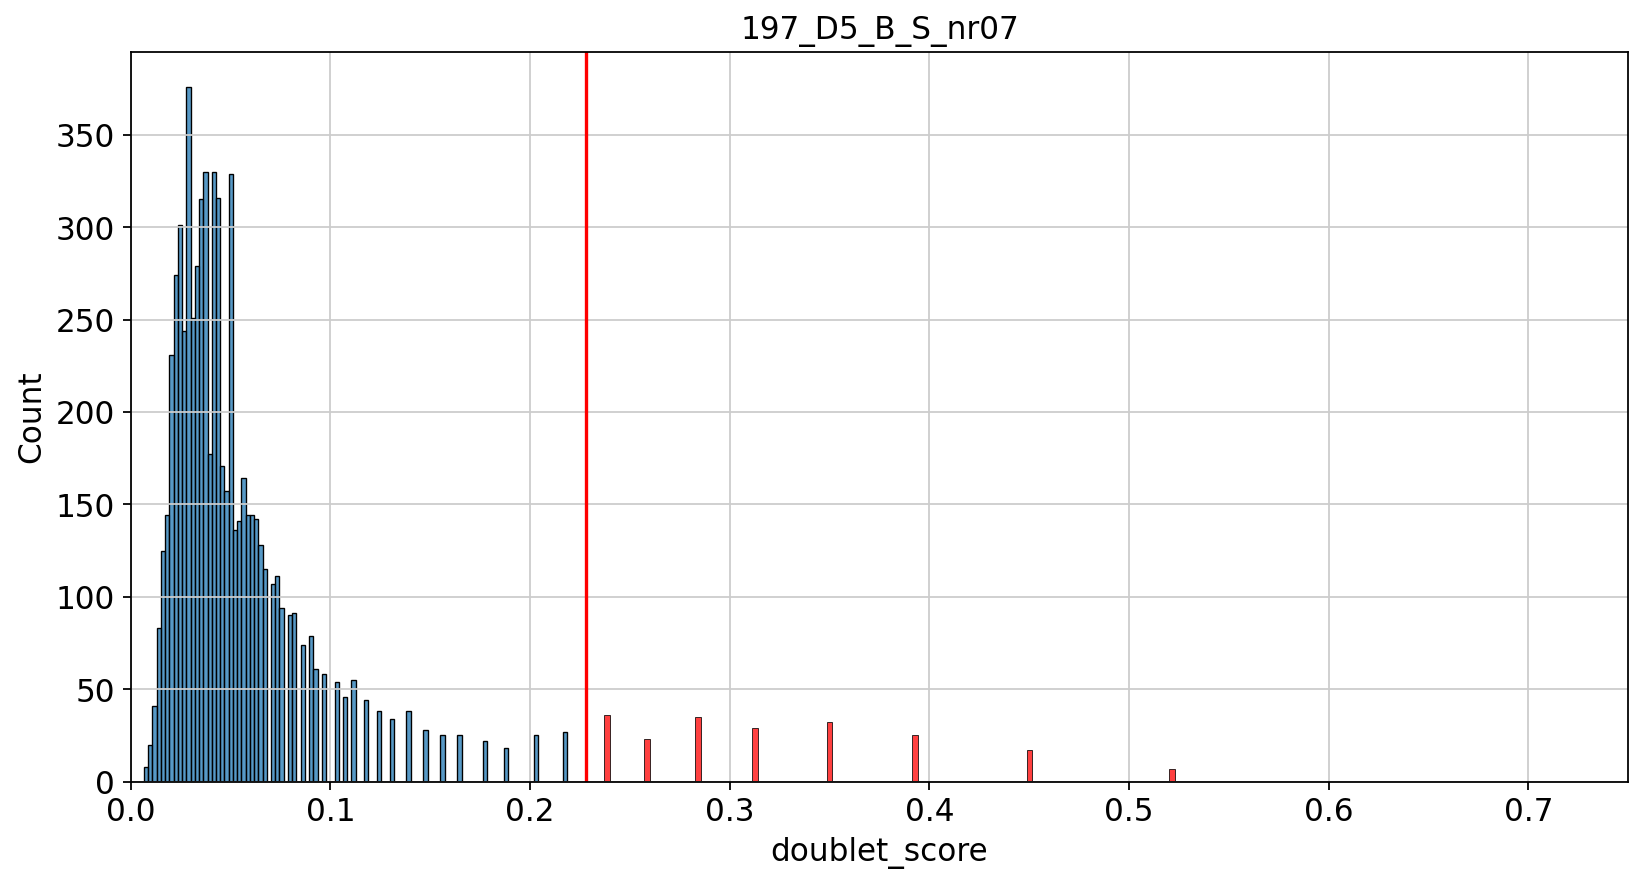

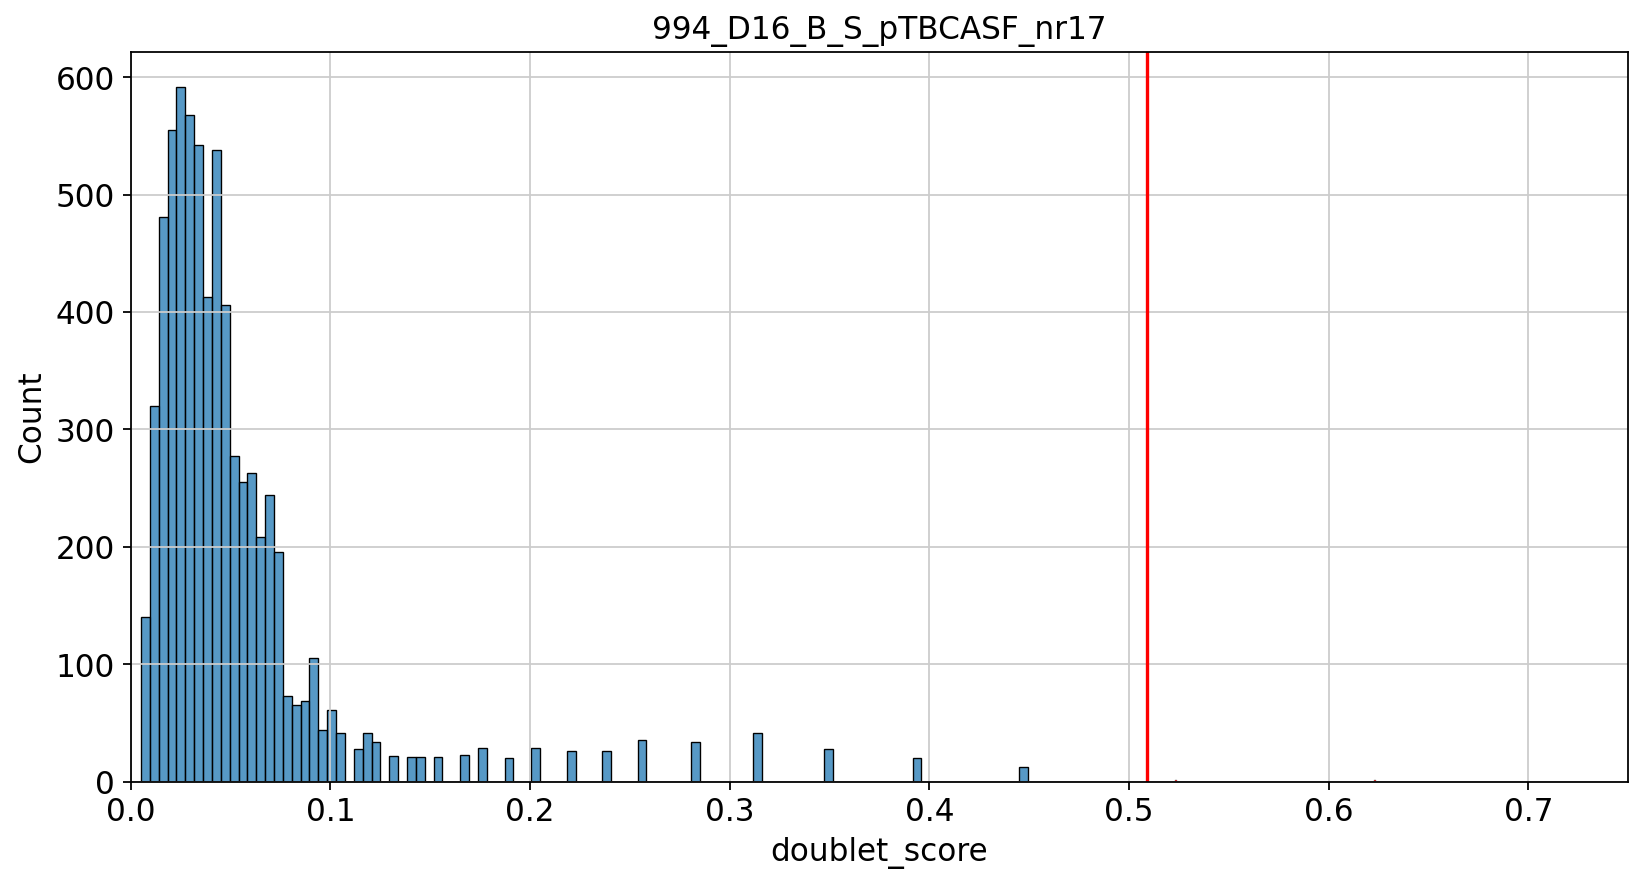

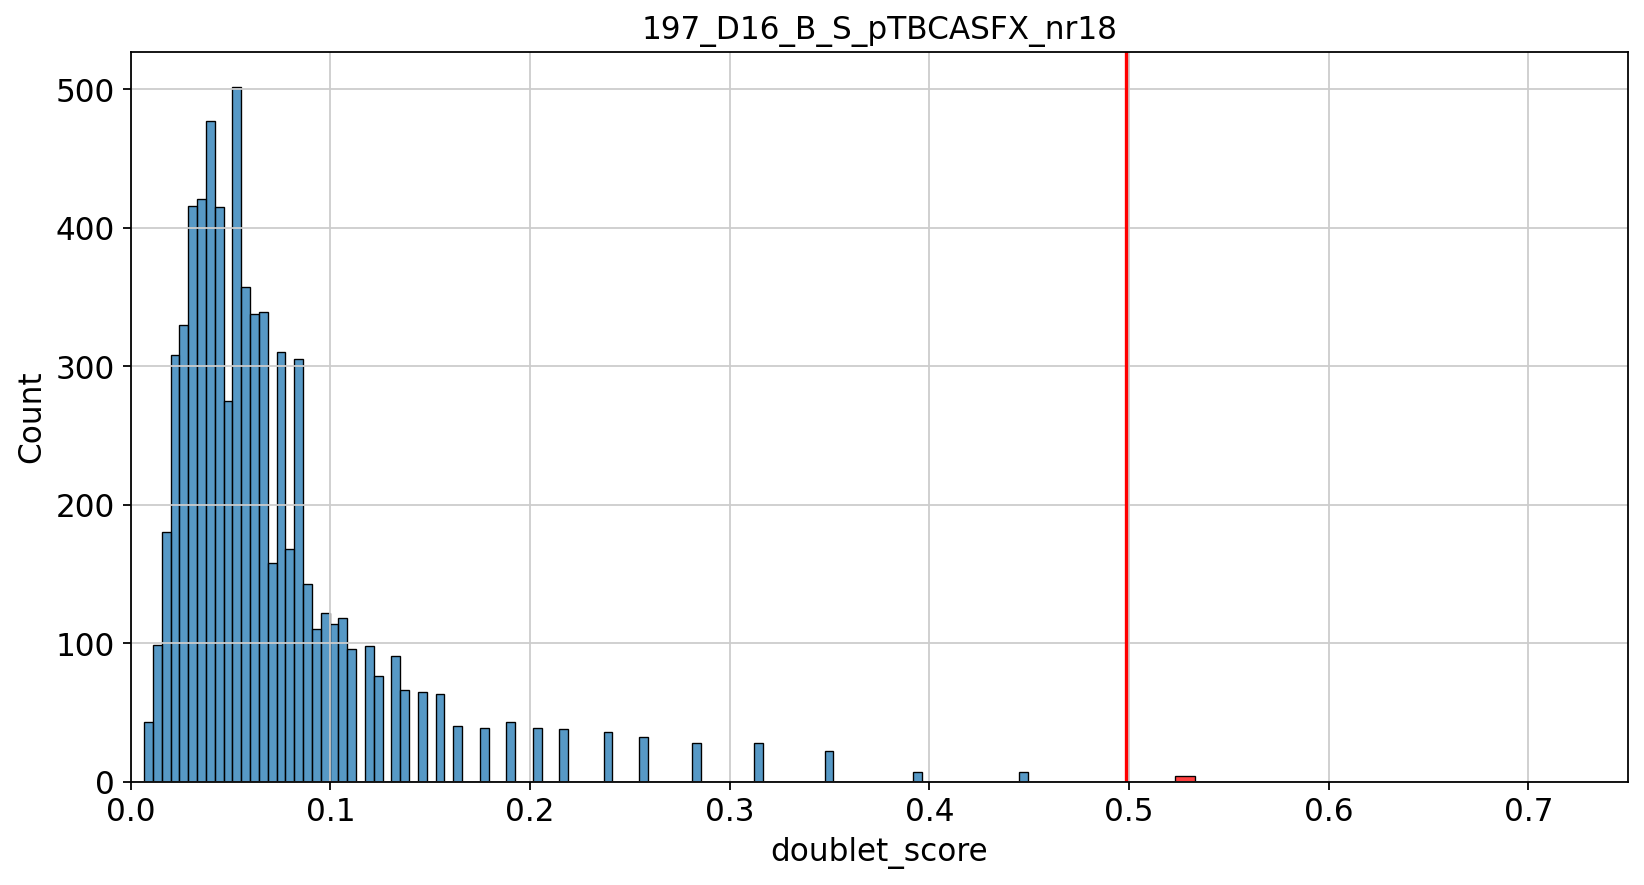

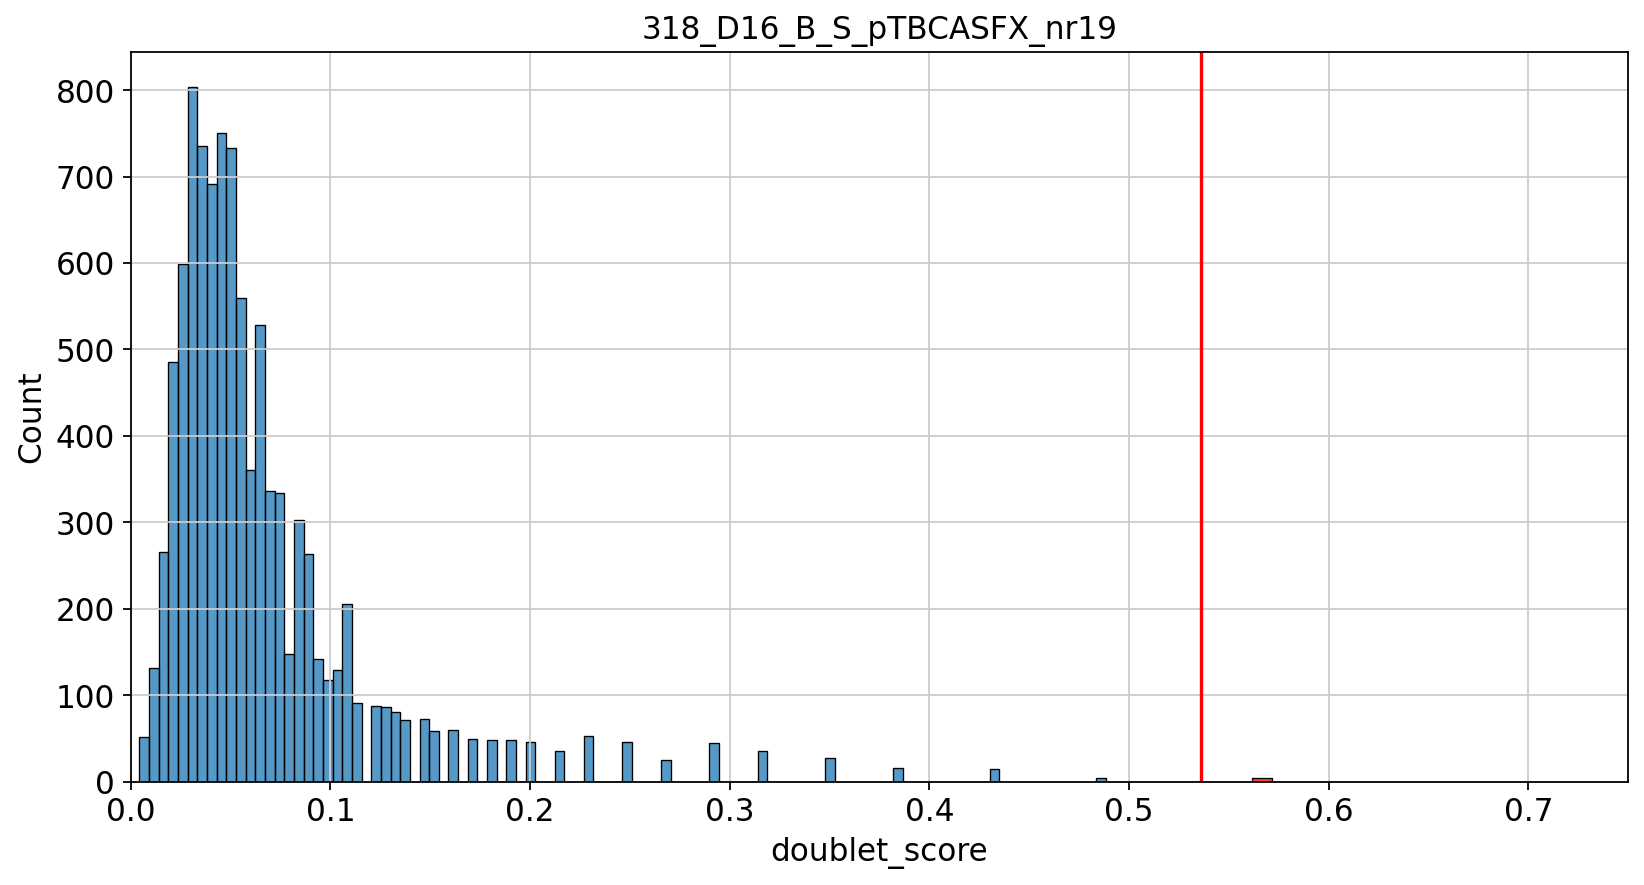

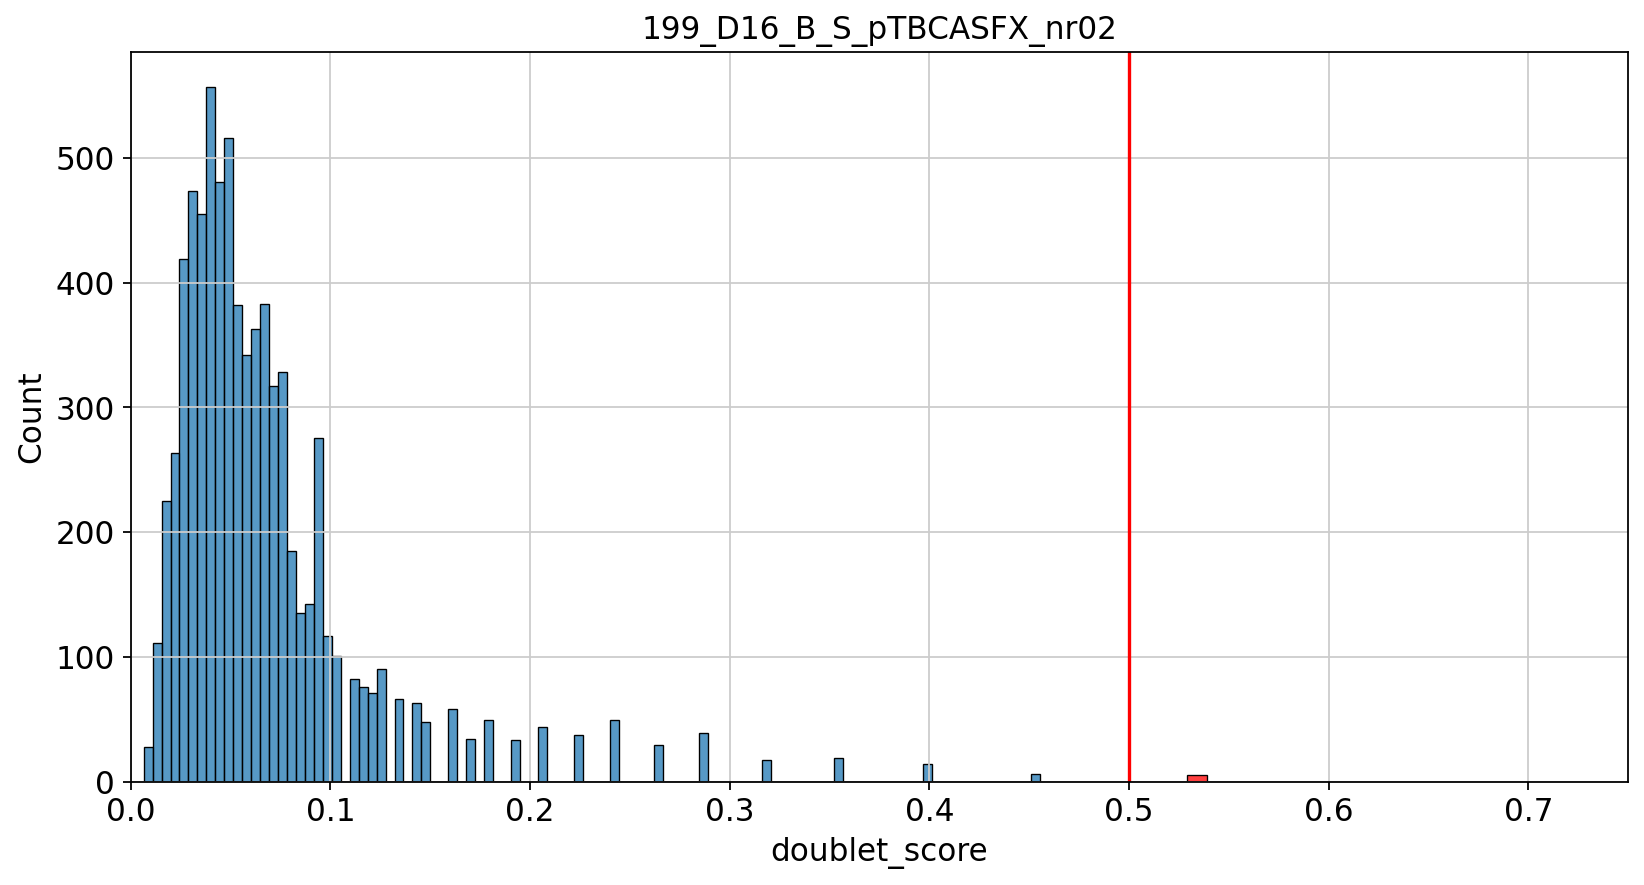

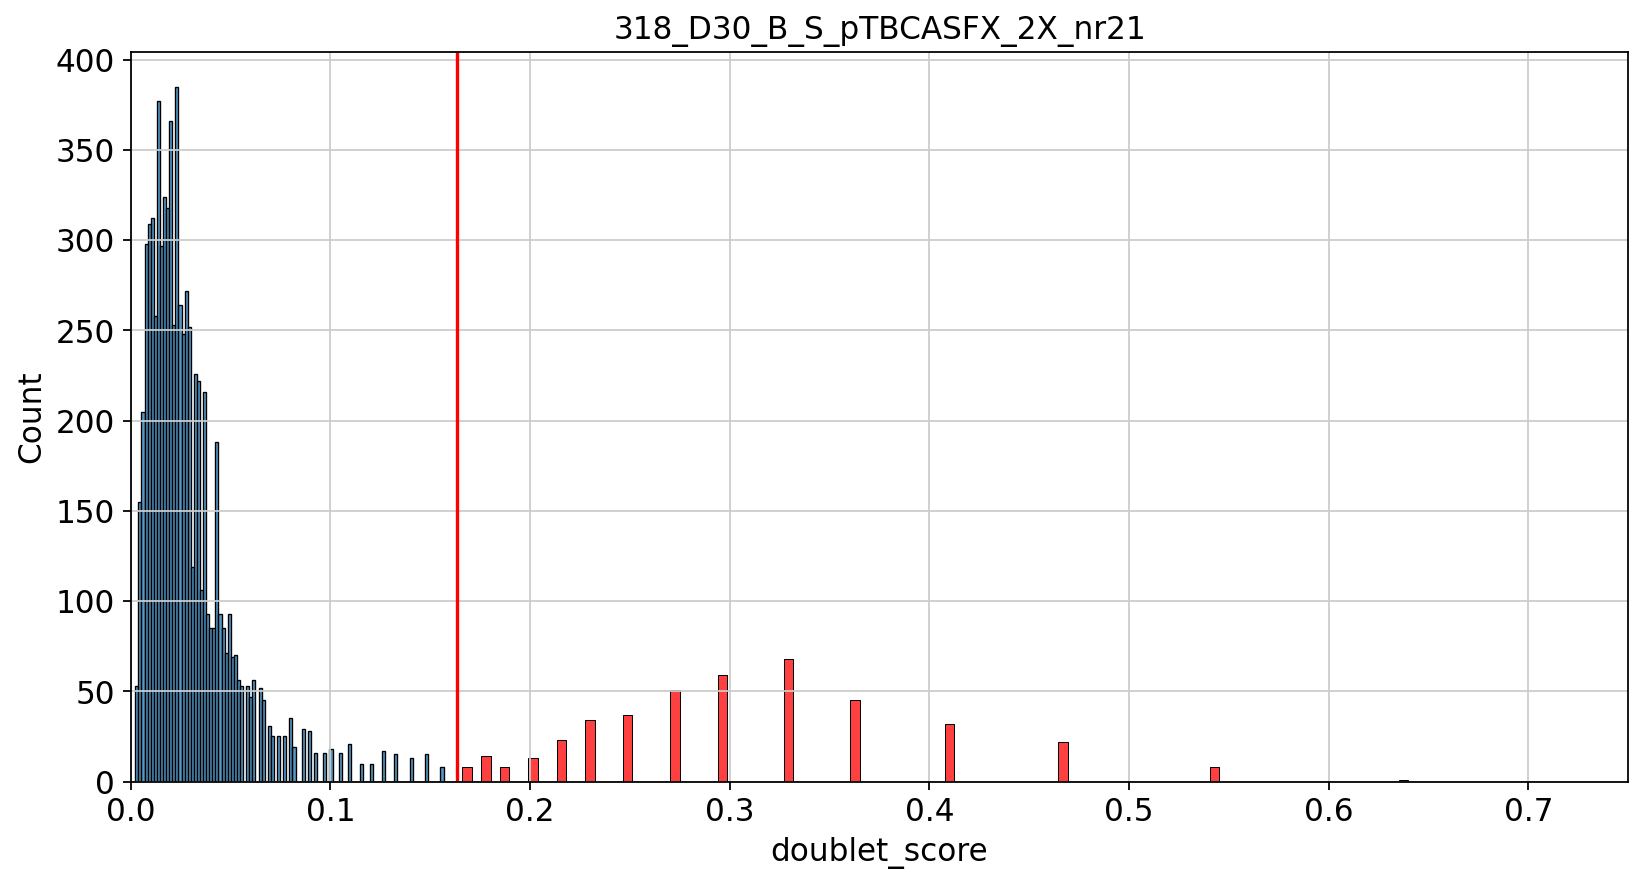

In [24]:
for run in adata.obs["run"].unique():
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    adata_subset = adata[adata.obs["run"] == run,:].copy()
    score_thr = adata_subset.uns["scrublet"]['batches'][run]['threshold']
    adata_singlets = adata_subset[~adata_subset.obs["predicted_doublet"],:]
    adata_doublets = adata_subset[adata_subset.obs["predicted_doublet"],:]

    # Plot the sinlgets
    sns.histplot(adata_singlets.obs["doublet_score"], 
                bins=100,
                ax=ax,
                )

    # Plot the doublets
    sns.histplot(adata_doublets.obs["doublet_score"], 
                bins=100, 
                color='red',
                ax=ax,
                ).set(title=run);
    ax.set_xlim(0,0.75)

    # Vertical line at the score threshold
    plt.axvline(score_thr, color='red')

    plt.show()

## Remove doublets    
* Remove identified doublets
* Also remove all cells with `doublet_Score` above 0.2
* This is maybe a crude approach, but for now we observed it works well
* For future iterations, consider doing something smarter, possibly altering the params of scrublet

In [25]:
adata = adata[~adata.obs["predicted_doublet"],:]
# Converting predicted doublet from boolean to categorical variable so it can be opened by cellxgene 
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")
adata = adata[adata.obs["doublet_score"]<0.2]

/tmp/ipykernel_1016619/3879258476.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")


## Normalization
The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [26]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_1016619/2262359327.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [27]:
%%memit
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:01)
peak memory: 25752.73 MiB, increment: 4454.42 MiB


## Dissociation genes on normalized data
* Calculate the expression of dissociation genes as a fraction of total expression (for details see 10.1038/nmeth.4437)
* We calculate it on normalized counts

In [28]:
%%memit
stress_genes = ["Actg1", "Ankrd1", "Arid5a", "Atf3", "Atf4", 
    "Bag3", "Bhlhe40", "Brd2", "Btg1", "Btg2", "Ccnl1", 
    "Ccrn4l", "Cebpb", "Cebpd", "Cebpg", "Csrnp1", 
    "Cxcl1", "Cyr61", "Dcn", "Ddx3xX", "Ddx5", "Des", 
    "Dnaja1", "Dnajb1", "Dnajb4", "Dusp1", "Dusp8", 
    "Egr1", "Egr2", "Eif1", "Eif5", "Erf", "Errfi1", 
    "Fam132b", "Fos", "Fosb", "Fosl2", "Gadd45a", 
    "Gcc1", "Gem", "H3f3b", "Hipk3", "Hsp90aa1", 
    "Hsp90ab1", "Hspa1a", "Hspa1b", "Hspa5", "Hspa8", 
    "Hspb1", "Hsph1", "Id3", "Idi1", "Ier2", "Ier3", 
    "Ifrd1", "Il6", "Irf1", "Irf8", "Itpkc", "Jun", 
    "Junb", "Jund", "Klf2", "Klf4", "Klf6", "Klf9", 
    "Litaf", "Lmna", "Maff", "Mafk", "Mcl1", "Midn", 
    "Mir22hg", "Mt1", "Mt2", "Myadm", "Myc", "Myd88", 
    "Nckap5l", "Ncoa7", "Nfkbia", "Nfkbiz", "Nop58", 
    "Nppc", "Nr4a1", "Odc1", "Osgin1", "Oxnad1", 
    "Pcf11", "Pde4b", "Per1", "Phlda1", "Pnp", "Pnrc1", 
    "Ppp1cc", "Ppp1r15a", "Pxdc1", "Rap1b", "Rassf1", 
    "Rhob", "Rhoh", "Ripk1", "Sat1X", "Sbno2", "Sdc4", 
    "Serpine1", "Skil", "Slc10a6", "Slc38a2", "Slc41a1", 
    "Socs3", "Sqstm1", "Srf", "Srsf5", "Srsf7", 
    "Stat3", "Tagln2", "Tiparp", "Tnfaip3", "Tnfaip6", 
    "Tpm3", "Tppp3", "Tra2a", "Tra2b", "Trib1", "Tubb4b", 
    "Tubb6", "Ubc", "Usp2", "Wac", "Zc3h12a", "Zfand5", 
    "Zfp36", "Zfp36l1", "Zfp36l2", "Zyx", "Gadd45g", 
    "Hspe1", "Ier5", "Kcne4"]
stress_genes = [gene.upper() for gene in stress_genes]

# Sum the counts of each cell accross all genes
sum_rows = adata.X.sum(axis=1)

# Subset the adata object to only include the stress genes
adata_stress_genes = adata[:, adata.var.index.isin(stress_genes)]
sum_row_stress = adata_stress_genes.X.sum(axis=1)
adata.obs["pct_dis"] = sum_row_stress/sum_rows

peak memory: 21298.25 MiB, increment: 0.00 MiB


<Axes: xlabel='pct_dis', ylabel='Count'>

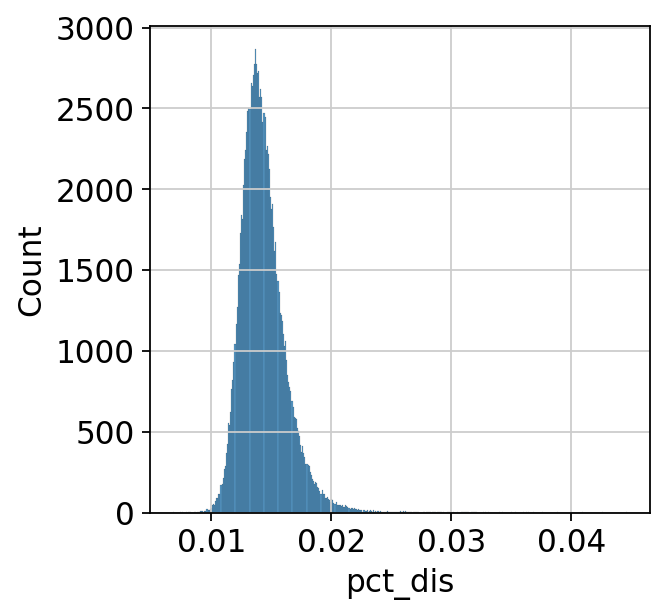

In [29]:
sns.histplot(adata.obs["pct_dis"])

## Filter on dissociation content
Remove cells with more than 6% of gene expression coming from dissociation genes

In [30]:
adata = adata[adata.obs['pct_dis']<0.06,:]
adata

View of AnnData object with n_obs × n_vars = 119003 × 17462
    obs: 'run', 'cell_line', 'day', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'pct_dis'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'run_colors', 'scrublet', 'log1p'
    layers: 'counts'

## Feature selection
As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function pp.highly_variable_genes annotates highly variable genes by reproducing the implementations of Seurat [Satija et al., 2015], Cell Ranger [Zheng et al., 2017], and Seurat v3 [Stuart et al., 2019] depending on the chosen flavor.

In [31]:
%%memit
sc.pp.highly_variable_genes(adata, 
                            n_top_genes=2000, 
                            )


extracting highly variable genes


    finished (0:00:37)


/exports/sasc/ioannis/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:664: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
peak memory: 34994.21 MiB, increment: 13695.95 MiB


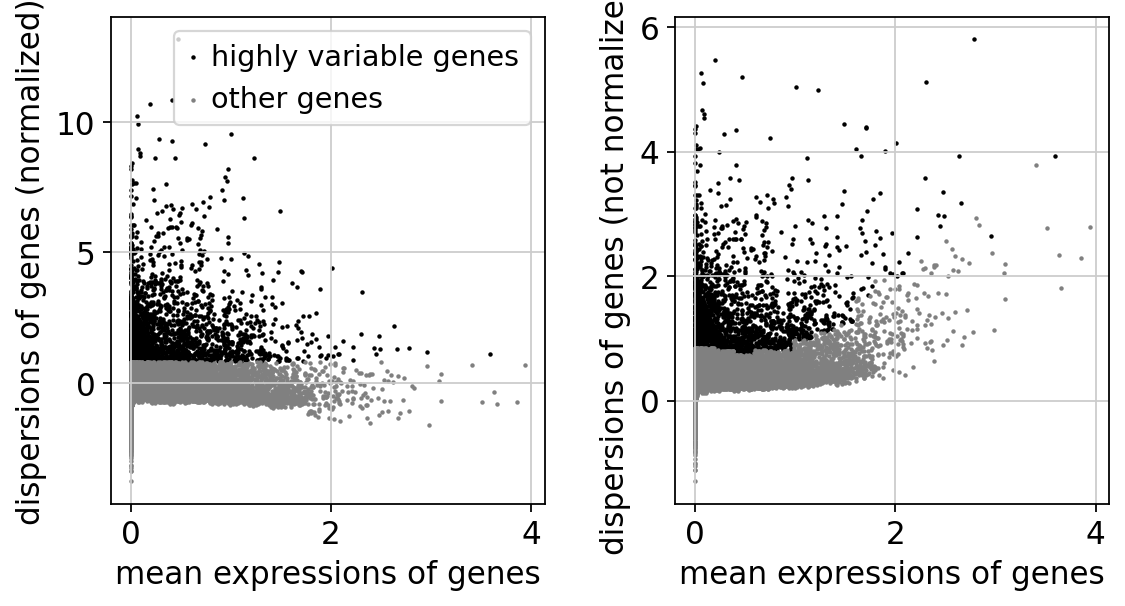

In [32]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [33]:
%%memit
sc.tl.pca(adata)

computing PCA
    with n_comps=50


    finished (0:00:17)
peak memory: 31613.97 MiB, increment: 1156.84 MiB


Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function leiden() or tsne(). In our experience, there does not seem to be signifigant downside to overestimating the numer of principal components.

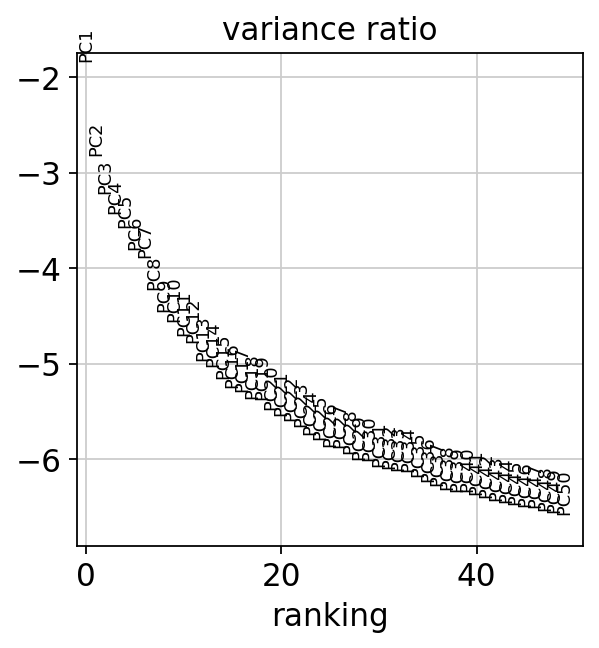

In [34]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

You can also plot the principal components to see if there are any potentially undesired features (e.g. batch, QC metrics) driving signifigant variation in this dataset. In this case, there isn’t anything too alarming, but it’s a good idea to explore this.

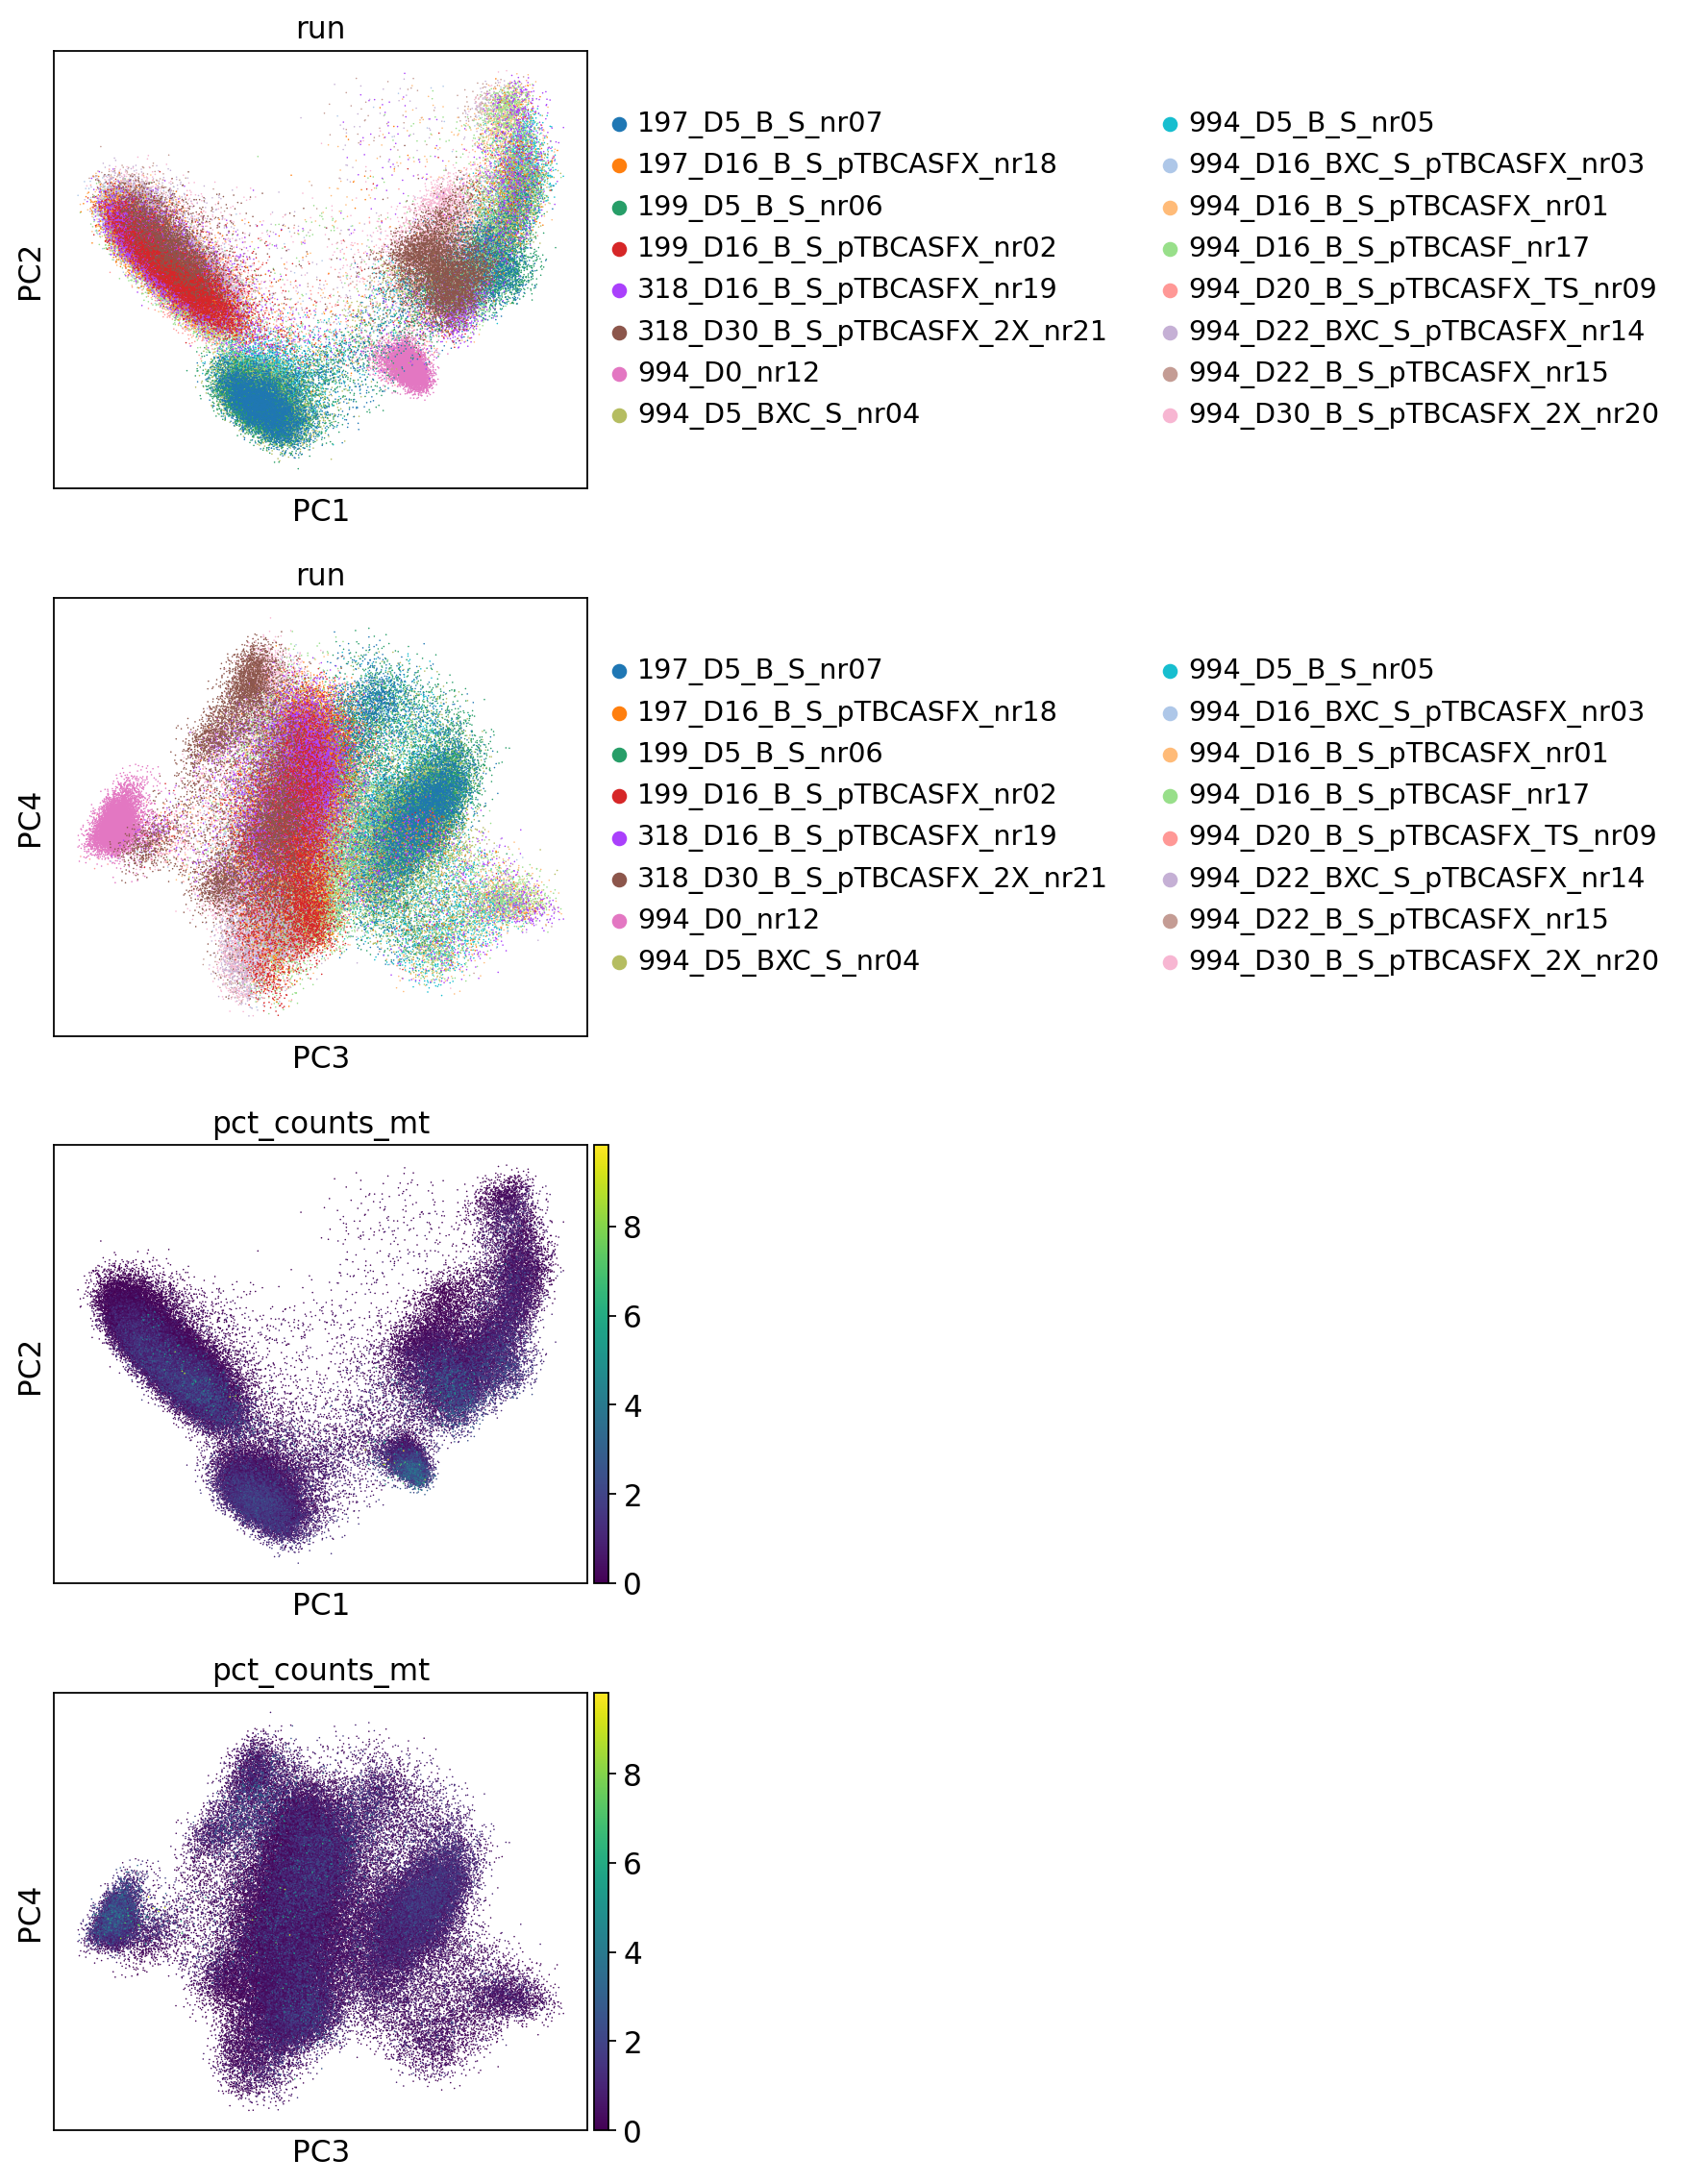

In [35]:
sc.pl.pca(
    adata,
    color=["run", "run", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=1,
    size=2,
)

## Nearest neighbor graph constuction and visualization
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.

In [36]:
%%memit
sc.pp.neighbors(adata,
                n_pcs=15,
                )

computing neighbors
    using 'X_pca' with n_pcs = 15


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
peak memory: 30471.86 MiB, increment: 13.71 MiB


In [37]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:12)


## Clustering
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) [Traag et al., 2019]. Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [38]:
%%memit
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, 
             flavor="igraph", 
             n_iterations=2,
             resolution=0.12,
             )

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)
peak memory: 30751.06 MiB, increment: 279.35 MiB


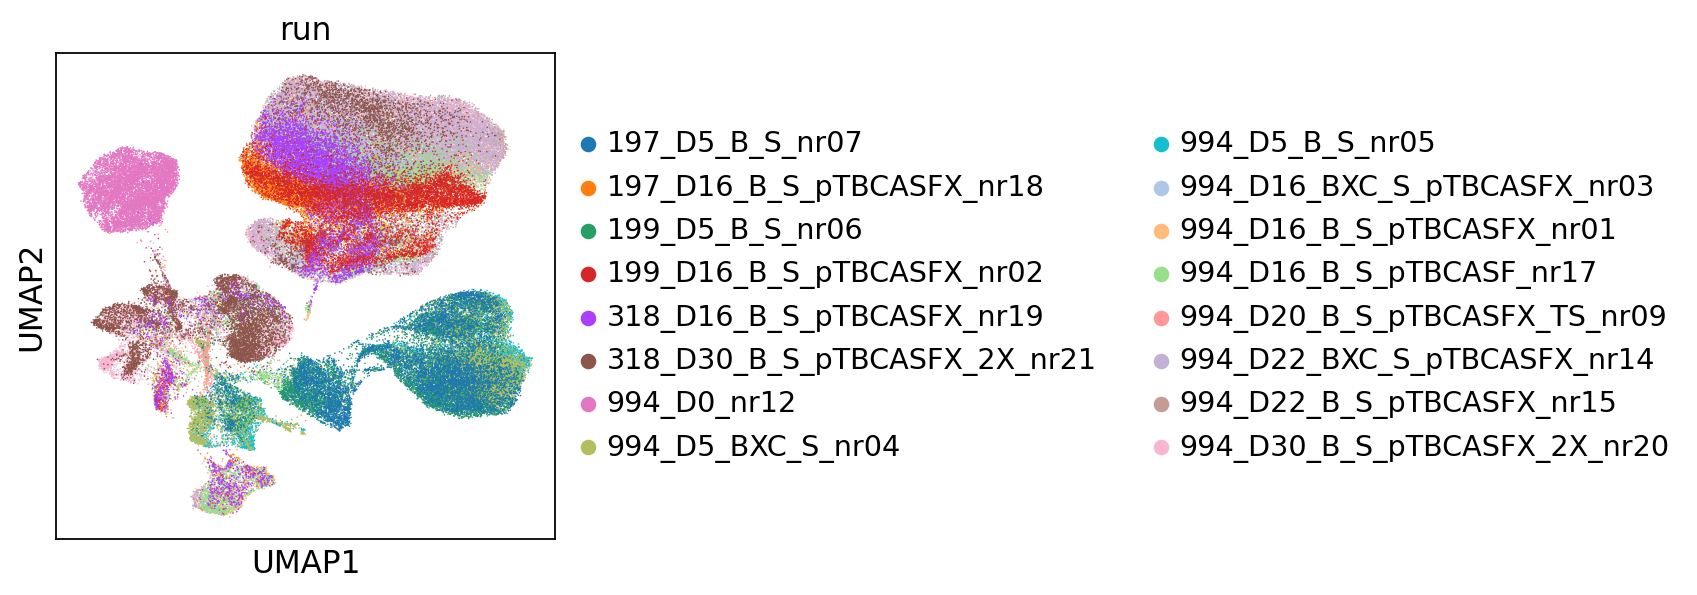

In [39]:
sc.pl.umap(
    adata,
    color="run",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

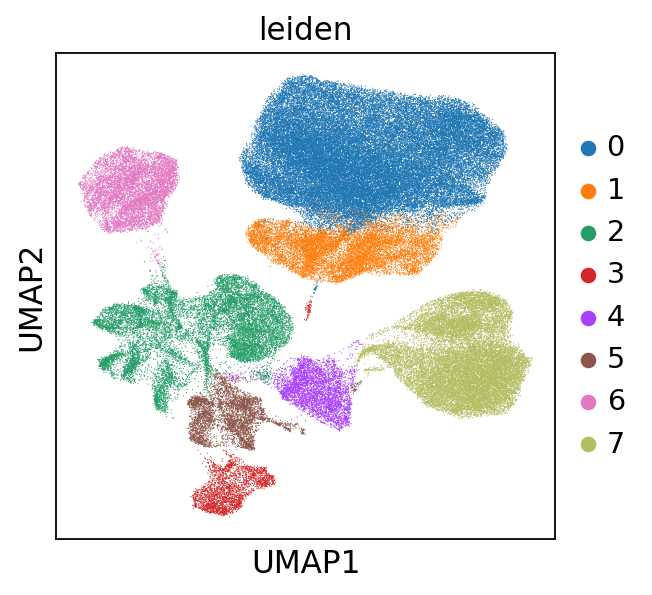

In [40]:
sc.pl.umap(adata, 
color=["leiden"],
)

## Re-assess quality control and cell filtering
As indicated before, we will now re-assess our filtering strategy by visualizing different QC metrics using UMAP.

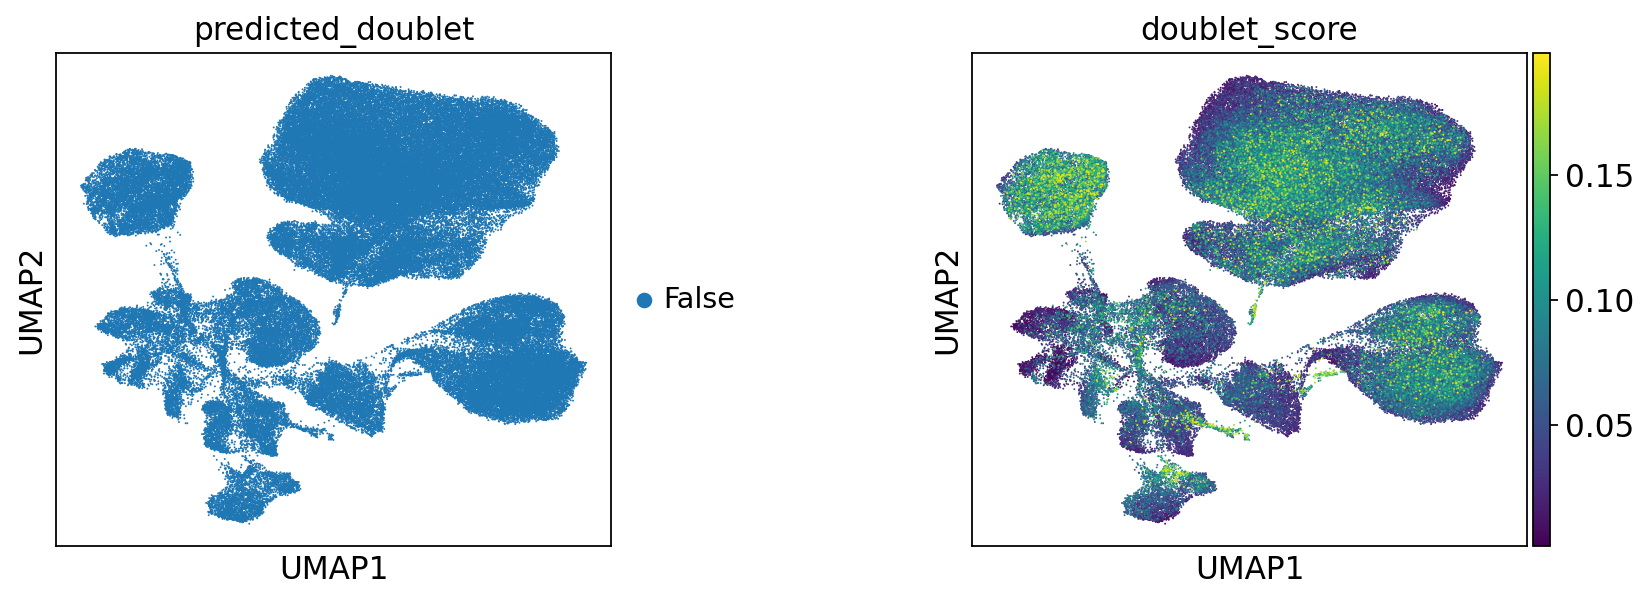

In [41]:
sc.pl.umap(
    adata,
    color=["predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

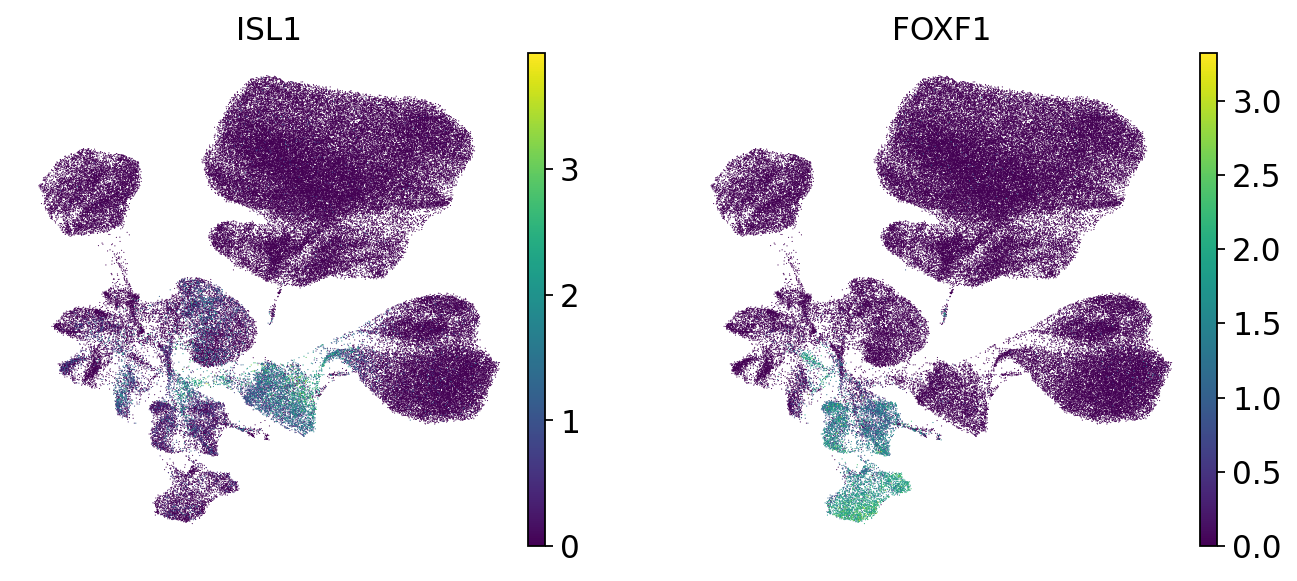

In [42]:
sc.pl.umap(
    adata,
    color=["ISL1", "FOXF1"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

In [3]:
# Save the object
adata.write_h5ad("arend_pgclcs_scanpy.h5ad")
# adata = sc.read_h5ad("arend_pgclcs_scanpy.h5ad")

## Subsample object
Get only a fifth of the original cells and save to make working with it easier

In [4]:
%%memit
adata_subsamples = sc.pp.subsample(adata, 
                                   n_obs=30000,
                                   copy=True,
                                   random_state=42,
)

peak memory: 13142.24 MiB, increment: 3327.03 MiB


In [6]:
adata_subsamples

AnnData object with n_obs × n_vars = 30000 × 17462
    obs: 'run', 'cell_line', 'day', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'pct_dis', 'leiden'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'predicted_doublet_colors', 'run_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities'

In [7]:
adata_subsamples.write_h5ad("arend_pgclcs_scanpy_subsampled_30000.h5ad")

## Differentially-expressed Genes as Markers
Furthermore, one can also calculate marker genes per cluster and then look up whether we can link those marker genes to any known biology, such as cell types and/or states. This is typically done using simple statistical tests, such as Wilcoxon and t-test, for each cluster vs the rest.

In [47]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata_subsamples, 
                        groupby="leiden", 
                        method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:39)


## Get the DEGs


In [48]:
# Have a look at the resulting structure
adata_subsamples.uns["rank_genes_groups"]

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('NANOS3', 'TACC3', 'MDK', 'COL3A1', 'GABRP', 'NID2', 'DNMT3B', 'ID1'),
            ('SUSD2', 'NUSAP1', 'HMGA2', 'LUM', 'HAND1', 'BAMBI', 'CD24', 'PRKAR2B'),
            ('SMARCA2', 'TOP2A', 'CRABP2', 'SPARC', 'KRT8', 'COL1A1', 'TERF1', 'CACNA2D2'),
            ...,
            ('SMS', 'MDK', 'PLPP1', 'TUBB2B', 'PDPN', 'EPCAM', 'COL4A2', 'VIM'),
            ('NT5DC2', 'FTL', 'PIM2', 'EPCAM', 'ENO2', 'SPINT2', 'PLOD1', 'TP53I11'),
            ('MDK', 'BASP1', 'PDPN', 'SPINT2', 'ETV4', 'IGFBP2', 'AHNAK', 'IGFBP2')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')]),
 'scores': rec.array([(118.86541 ,  66.52648 ,  79.09037 ,  45.032307,  55.083805,  55.142796,  74.69404 , 107.64153 ),
            (118.36324 ,  64.045876,  77.634636,  44.648056,  54.9

In [49]:
# Get the top 10 differentially expressed genes for cluster 0
sc.get.rank_genes_groups_df(adata_subsamples, group="0").head(10)

names      scores  logfoldchanges  pvals  pvals_adj
0     NANOS3  118.865410        3.690644    0.0        0.0
1      SUSD2  118.363243        3.590606    0.0        0.0
2    SMARCA2  117.935661        2.995799    0.0        0.0
3  RAB11FIP4  116.878029        2.690768    0.0        0.0
4      ITGA6  114.809349        2.310190    0.0        0.0
5    TFCP2L1  112.149338        2.931466    0.0        0.0
6      PLBD1  109.777061        2.693595    0.0        0.0
7      SMAGP  108.656342        2.437199    0.0        0.0
8       ESAM  106.435616        3.403486    0.0        0.0
9      RAB17  105.941879        3.167700    0.0        0.0

In [50]:
# Get all differentially expressed genes and filter 
degs = sc.get.rank_genes_groups_df(adata_subsamples, group=None)
degs_filtered = degs[degs['pvals_adj']<0.05]
degs_filtered.to_csv("DEGs_subsampled_0.2.csv")